In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import csv

In [7]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.size'] = 18
font = {'size'   : 18}
matplotlib.rc('font', **font)

In [379]:
# Load data inputs used in optimization model

generators = pd.read_csv("Data/GeneratorsNetwork.csv")
storage_elec = pd.read_csv("Data/Storage_ELECNetwork.csv")
storage_gas = pd.read_csv("Data/Storage_GASNetwork.csv")
p2g = pd.read_csv("Data/PowerToGasNetwork.csv")
appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")
resources = pd.read_csv("Plots/generators.csv")

GEN = len(generators)
STORAGE_ELEC = len(storage_elec)
STORAGE_GAS = len(storage_gas)
P2G = len(p2g)

resource_list = np.append(np.append(np.append(generators["Prime Mover"].to_numpy(), storage_elec["Prime Mover"].to_numpy()), p2g["Prime Mover"].to_numpy()), storage_gas["Prime Mover"].to_numpy())
resource_list = np.where(resource_list == "Net-zero CH4", "Electro-methane",resource_list)
resource_list_GEN = (generators["Prime Mover"].to_numpy())
resource_list_P2G = (p2g["Prime Mover"].to_numpy())
resource_list_P2G = np.where(resource_list_P2G == "Net-zero CH4", "Electro-methane",resource_list_P2G)

unique_resources = np.append(np.append(np.append(generators["Prime Mover"].drop_duplicates().to_numpy(), storage_elec["Prime Mover"].drop_duplicates().to_numpy()), p2g["Prime Mover"].drop_duplicates().to_numpy()), storage_gas["Prime Mover"].drop_duplicates().to_numpy())
unique_resources_GEN = generators["Prime Mover"].drop_duplicates().to_numpy()
unique_resources_STORAGE = np.append(storage_elec["Prime Mover"].drop_duplicates().to_numpy(), storage_gas["Prime Mover"].drop_duplicates().to_numpy())
unique_resources_P2G = p2g["Prime Mover"].drop_duplicates().to_numpy()
unique_resources_P2G = np.where(unique_resources_P2G == "Net-zero CH4", "Electro-methane",unique_resources_P2G)

locational_resources = np.append(np.append(np.append(generators["Node_ELEC"].to_numpy(), storage_elec["Node_ELEC"].to_numpy()), p2g["Node_ELEC"].to_numpy()), storage_gas["Node_ELEC"].to_numpy())
locational_resources_GEN = generators["Node_ELEC"].to_numpy()

appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")
appliances_gascons = pd.read_csv("Data/ApplianceProfiles_GASNetworkCold.csv")
appliances_eleccons = pd.read_csv("Data/ApplianceProfiles_ELECNetworkCold.csv")
unique_appliancetypes =  appliances["Appliance Name"].drop_duplicates().to_numpy()
appliances_list = appliances["Appliance Name"].to_numpy()
locational_resources_appliances = appliances["Node_ELEC"].to_numpy()

In [521]:
caseNum = 1
date_stamps = ["AC Savings Yes"] 
case_studies = date_stamps
case_names = date_stamps

case1 = case_names[caseNum-1]
date_stamp1 = date_stamps[caseNum-1]
case_study = "Reference"

folder1 = "core/Output/%s" % date_stamp1
folder = folder1

system = "Network"
region = "Cold"

# T_inv = 1
# Years = 2020
T_inv = 5
Years = np.array([2025,2030,2035,2040,2045])

## Gas and Electric Capacity Expansion and Annual Generation

In [518]:
resources = pd.read_csv("Plots/generators.csv")
resource_list = resources["Clumps"].to_numpy()
resource_list_GEN = resource_list[:237]
unique_resources = resources["Clumps"].drop_duplicates().to_numpy()
unique_resources = np.array(['Coal', 'Natural Gas', 'Biomass', 'Geothermal', 'Nuclear',
 'Hydro', 'Solar PV', 'Wind', 'Offshore Wind',
 'Short-Duration Storage', 'Long-Duration Storage','Power-to-Gas'])
unique_resources_GEN = unique_resources[:-3]
colors = np.array(['#000000','#888888', '#00767B', '#E94C1F', '#A01813',
    '#C6DBED', '#F9D576','#60BCE9', '#238F9D', 
    '#FFB954', '#F57634','#125A56'])
colors_GEN = colors[:-3]

p2g = pd.read_csv("Data/PowerToGasNetwork.csv")
resource_list_P2G = (p2g["Prime Mover"].to_numpy())
resource_list_P2G = np.where(resource_list_P2G == "Net-zero CH4", "Electro-methane",resource_list_P2G)
unique_resources_P2G = np.array(['Biomethane', 'Net-zero CH4','Electrolytic Hydrogen'])
unique_resources_P2G = np.where(unique_resources_P2G == "Net-zero CH4", "Electro-methane",unique_resources_P2G)
colors_P2G = np.array(['#125A56', '#238F9D','#60BCE9'])

Installed Capacity:  [ 13.44491794  35.8355842   68.54449475 115.26901629 185.25529516] 

Total Generation:  [282.61987224 308.4825067  419.489216   530.75111059 631.10876951] 

Gas Demands : [443.46953407 436.02160132 538.2023388  401.02402278 185.86210487]
Appliances : [52.01534096 34.866368   21.95628585 15.46120437  5.56987228]
Power Generation : [2.11163897e+02 2.20864937e+02 3.35955757e+02 2.05272522e+02
 1.93659139e-03]


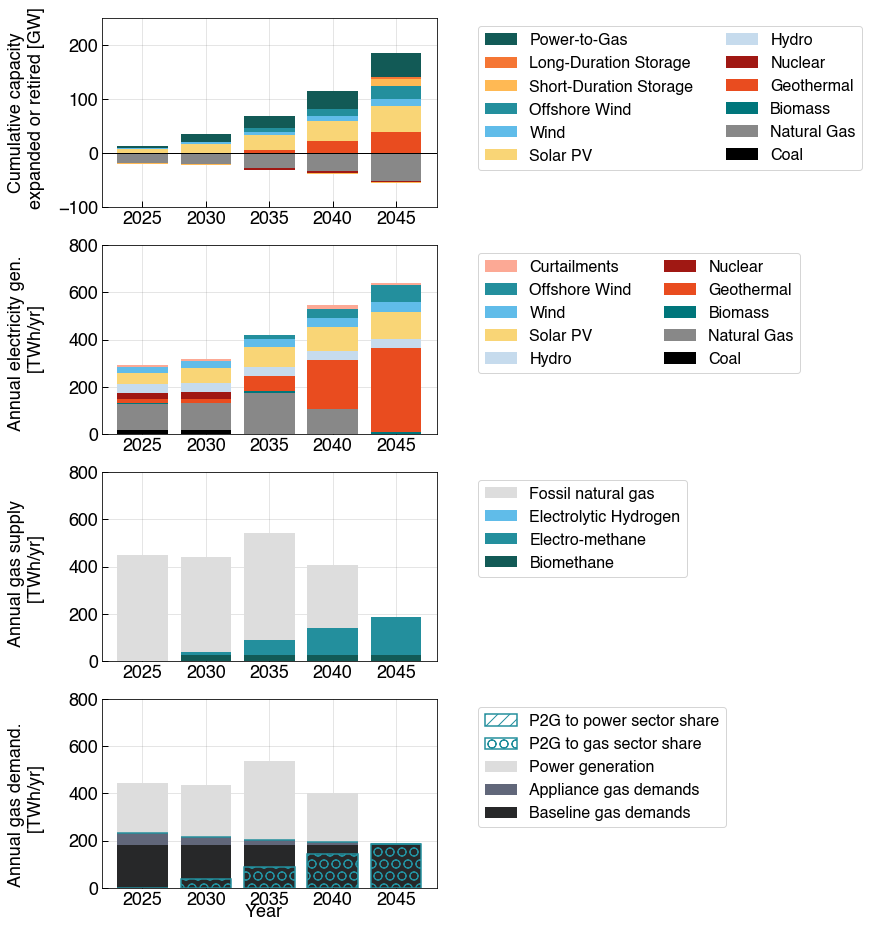

In [522]:
fig, axes = plt.subplots(4, 1, figsize = (6,16))
folder = folder1

#############################
## Total capacity built and retired
resources = np.zeros((len(unique_resources),T_inv))
resources_minus = np.zeros((len(unique_resources),T_inv))
cap_built = pd.read_csv(f"%s/CAPACITY_BUILT.csv" % folder).to_numpy()
cap_built = cap_built[0:-1,:]
cap_retired = pd.read_csv(f"%s/CAPACITY_RETIRED.csv" % folder).to_numpy()
cap_retired = cap_retired[0:-1,:]
hourly_load = pd.read_csv(f"%s/HOURLY_LOAD.csv" % folder).to_numpy()
stack = np.zeros((T_inv))
stack_minus = stack.copy()

for k in range(len(unique_resources)):
    for j in range(T_inv):
        for jj in range(j+1):
            resources_minus[k,j] = resources_minus[k,j]+np.sum(cap_retired[resource_list == unique_resources[k],jj],0)
            resources[k,j] = resources[k,j]+np.sum(cap_built[resource_list == unique_resources[k],jj],0)
    
    if sum(resources[k,:]) > 0:
        axes[0].bar(Years, resources[k,:]/10**3, label = unique_resources[k], bottom = stack, width = 4, align = "center", color = colors[k])
        stack = stack + resources[k,:]/10**3
    if sum(resources_minus[k,:]) > 0:
        if sum(resources[k,:]) > 0:
            axes[0].bar(Years, -1*resources_minus[k,:]/10**3, bottom = stack_minus, width = 4, align = "center", color = colors[k])
        if sum(resources[k,:]) <= 0:
            axes[0].bar(Years, -1*resources_minus[k,:]/10**3, label = unique_resources[k], bottom = stack_minus, width = 4, align = "center", color = colors[k])
        stack_minus = stack_minus - resources_minus[k,:]/10**3
    
    # print(unique_resources[k],resources[k,j]/10**3)
    if k == len(unique_resources)-1:
        print("Installed Capacity: ",stack, "\n")

#############################
## Total electric generation
generation = pd.read_csv(f"%s/GENERATION.csv" % folder).to_numpy()
data_elec = generation[GEN+P2G:GEN+P2G+8,:].copy()
generation = generation[0:GEN,:].copy()
stack = np.zeros((T_inv))
for k in range(len(unique_resources_GEN)):
    resources = np.sum(generation[resource_list_GEN == unique_resources_GEN[k],:],0)
    axes[1].bar(Years, resources/10**6, label = unique_resources_GEN[k],color = colors_GEN[k], bottom = stack, width = 4, align = "center")
    stack = stack + resources/10**6
    # print(unique_resources_GEN[k],resources/10**6)
    if k == len(unique_resources_GEN)-1:
        print("Total Generation: ",stack, "\n")
resources = data_elec[7,:].copy()
axes[1].bar(Years, resources/10**6, label = "Curtailments", color = "#FCA995", linewidth = 2, ls = "--", bottom = stack, width = 4, align = "center")
electricity_stack = stack

resources = np.ones([1,5]) * data_elec[4,0].copy()
stack = np.zeros((T_inv))
# axes[1].bar(Years, resources[0]/10**6, label = "Initial electricity demand", color = "none", alpha = 1, edgecolor = 'tomato', linewidth = 2, ls = "--", bottom = stack, width = 4, align = "center")
resources = data_elec[5,:].copy()
stack = np.zeros((T_inv))
# axes[1].bar(Years, resources/10**6, label = "Final electricity demand", color = "none", alpha = 1, edgecolor = 'k', linewidth = 2, bottom = stack, width = 4, align = "center")

#############################
## Total annual gas generation
generation = pd.read_csv(f"%s/GENERATION.csv" % folder).to_numpy()
data_gas = generation[GEN+P2G:GEN+P2G+9,:]
generation = generation[GEN:GEN+P2G,:]
stack = np.zeros((T_inv))
for k in range(len(unique_resources_P2G)):
    resources = np.sum(generation[resource_list_P2G == unique_resources_P2G[k],:],0)
    axes[2].bar(Years, resources/10**6, label = unique_resources_P2G[k],color = colors_P2G[k], bottom = stack, width = 4, align = "center")
    stack = stack + resources/10**6
    
axes[2].bar(Years, np.maximum(data_gas[6,:].copy()/10**6,0), label = "Fossil natural gas", color = "#DDDDDD", bottom = stack, width = 4, align = "center")

#############################
## Total annual gas demand
data_baselinegas = np.sum(hourly_load[3,int((0)*24):int((365)*24)]) #kWh baseline gas consumption/yr

stack = np.zeros((T_inv))
resources_bg = np.ones([5]) * data_baselinegas/10**6
axes[3].bar(Years, resources_bg, label = "Baseline gas demands", color = "#272829", alpha = 1, bottom = stack, width = 4, align = "center")
resources = data_gas[1,:].copy()/10**6 - resources_bg
axes[3].bar(Years, resources, label = "Appliance gas demands", color = "#61677A", alpha = 1, bottom = resources_bg, width = 4, align = "center")
axes[3].bar(Years, np.maximum((data_gas[8,:].copy())/10**6,0), label = "Power generation",color = "#DDDDDD", alpha = 1, bottom = resources_bg+resources, width = 4, align = "center")
print("Gas Demands :", resources_bg+resources+data_gas[8,:].copy()/10**6)
print("Appliances :", resources)
print("Power Generation :", data_gas[8,:].copy()/10**6)

stack = np.zeros((T_inv))
resources3 = data_gas[3,:].copy()
axes[3].bar(Years, resources3/10**6, label = "P2G to gas sector share", color = "none", alpha = 1, hatch='O', edgecolor = '#238F9D',linewidth = 1.5, bottom = stack, width = 4, align = "center")

resources2 = data_gas[2,:].copy()
axes[3].bar(Years, resources2/10**6, label = "P2G to power sector share", color = "none", alpha = 1, hatch='//',edgecolor = '#238F9D',linewidth = 1.5, bottom = resources_bg+resources, width = 4, align = "center")
for ii in range(4):
    axes[ii].axhline(linewidth=1, color='k')
    axes[ii].tick_params(direction='in', length=6, width=1, colors='k')

for i in range(4):
    handles, labels = axes[i].get_legend_handles_labels()
    labels = np.where(np.array(labels) == "Electrolysis","Electrolytic hydrogen",np.array(labels))
    if i==0:
        axes[i].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.0), loc='upper left', prop={'size': 16},ncol=2)
    elif i ==1:
        axes[i].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.0), loc='upper left', prop={'size': 16},ncol=2)
    else:
        axes[i].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1), loc='upper left', prop={'size': 16})
    axes[i].set_axisbelow(True)
    axes[i].grid(color='grey', linestyle='-', linewidth=1,alpha = 0.2)

fig.text(-0.05, 0.8, 'Cumulative capacity \n expanded or retired [GW]', ha='center', va='center', rotation='vertical')
fig.text(-0.05, 0.6, 'Annual electricity gen. \n [TWh/yr]', ha='center', va='center', rotation='vertical')
fig.text(-0.05, 0.4, 'Annual gas supply \n [TWh/yr]', ha='center', va='center', rotation='vertical')
fig.text(-0.05, 0.2, 'Annual gas demand. \n [TWh/yr]', ha='center', va='center', rotation='vertical')

axes[0].set_ylim([-100,250])
axes[1].set_ylim([0,800])
axes[2].set_ylim([0,800])
axes[3].set_ylim([0,800])
fig.text(0.5, 0.1, 'Year', ha='center')
fig.savefig(f"Plots/{case_study}/Investment_Period_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()

Installed Capacity:  [  9.30533724  31.71299335  70.26899041 123.07175901 187.52492246] 

Total Generation:  [280.91015433 310.3320988  431.6247524  545.98824918 631.36026806] 

Gas Demands : [448.32971163 455.33469817 581.84094751 448.39846834 191.48812057]
Appliances : [59.88947599 49.35571687 38.45079399 29.73780694 11.18593849]
Power Generation : [2.08149940e+02 2.25688685e+02 3.63099858e+02 2.38370365e+02
 1.18860796e-02]


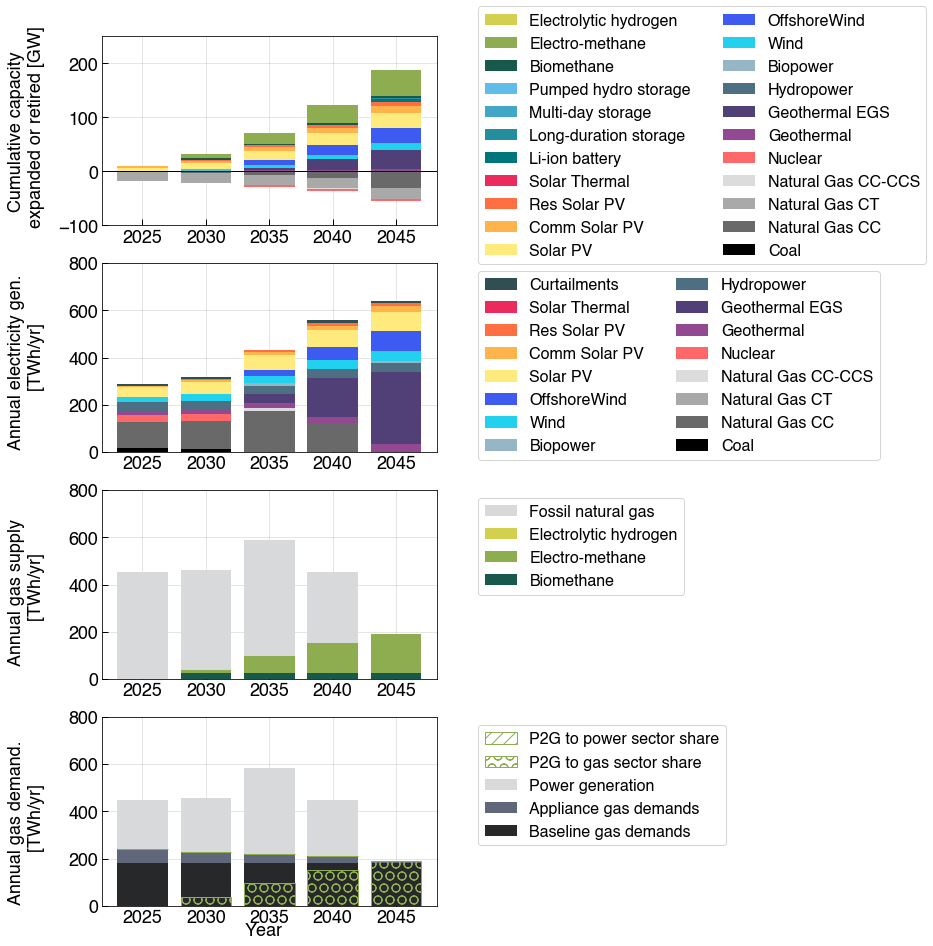

In [88]:
fig, axes = plt.subplots(4, 1, figsize = (6,16))
folder = folder1

# Total capacity built and retired
resources = np.zeros((len(unique_resources),T_inv))
resources_minus = np.zeros((len(unique_resources),T_inv))
cap_built = pd.read_csv(f"%s/CAPACITY_BUILT.csv" % folder).to_numpy()
cap_built = cap_built[0:-1,:]
cap_retired = pd.read_csv(f"%s/CAPACITY_RETIRED.csv" % folder).to_numpy()
hourly_load = pd.read_csv(f"%s/HOURLY_LOAD.csv" % folder).to_numpy()
cap_retired = cap_retired[0:-1,:]
stack = np.zeros((T_inv))
stack_minus = stack.copy()
for k in range(len(unique_resources)):
    for j in range(T_inv):
        for jj in range(j+1):
            resources_minus[k,j] = resources_minus[k,j]+np.sum(cap_retired[resource_list == unique_resources[k],jj],0)
            resources[k,j] = resources[k,j]+np.sum(cap_built[resource_list == unique_resources[k],jj],0)
    
    if sum(resources[k,:]) > 0:
        axes[0].bar(Years, resources[k,:]/10**3, label = unique_resources[k], bottom = stack, width = 4, align = "center", color = colors[k])
        stack = stack + resources[k,:]/10**3
    if sum(resources_minus[k,:]) > 0:
        if sum(resources[k,:]) > 0:
            axes[0].bar(Years, -1*resources_minus[k,:]/10**3, bottom = stack_minus, width = 4, align = "center", color = colors[k])
        if sum(resources[k,:]) <= 0:
            axes[0].bar(Years, -1*resources_minus[k,:]/10**3, label = unique_resources[k], bottom = stack_minus, width = 4, align = "center", color = colors[k])
        stack_minus = stack_minus - resources_minus[k,:]/10**3
    
    # print(unique_resources[k],resources[k,j]/10**3)
    if k == len(unique_resources)-1:
        print("Installed Capacity: ",stack, "\n")
data = pd.read_csv(f"%s/GENERATION.csv" % folder).to_numpy()

data_elec = data[GEN+P2G:GEN+P2G+8,:].copy()
data = data[0:GEN,:].copy()
stack = np.zeros((T_inv))
for k in range(len(unique_resources_GEN)):
    resources = np.sum(data[resource_list_GEN == unique_resources_GEN[k],:],0)
    axes[1].bar(Years, resources/10**6, label = unique_resources_GEN[k],color = colors_GEN[k], bottom = stack, width = 4, align = "center")
    stack = stack + resources/10**6
    # print(unique_resources_GEN[k],resources/10**6)
    if k == len(unique_resources_GEN)-1:
        print("Total Generation: ",stack, "\n")
resources = data_elec[7,:].copy()
axes[1].bar(Years, resources/10**6, label = "Curtailments", color = "#314E52", linewidth = 2, ls = "--", bottom = stack, width = 4, align = "center")
electricity_stack = stack

resources = np.ones([1,5]) * data_elec[4,0].copy()
stack = np.zeros((T_inv))
# axes[1].bar(Years, resources[0]/10**6, label = "Initial electricity demand", color = "none", alpha = 1, edgecolor = 'tomato', linewidth = 2, ls = "--", bottom = stack, width = 4, align = "center")
resources = data_elec[5,:].copy()
stack = np.zeros((T_inv))
# axes[1].bar(Years, resources/10**6, label = "Final electricity demand", color = "none", alpha = 1, edgecolor = 'k', linewidth = 2, bottom = stack, width = 4, align = "center")

#############################
## Total annual gas generation
data = pd.read_csv(f"%s/GENERATION.csv" % folder).to_numpy()
data_gas = data[GEN+P2G:GEN+P2G+9,:]
data = data[GEN:GEN+P2G,:]
stack = np.zeros((T_inv))
for k in range(len(unique_resources_P2G)):
    resources = np.sum(data[resource_list_P2G == unique_resources_P2G[k],:],0)
    axes[2].bar(Years, resources/10**6, label = unique_resources_P2G[k],color = colors_P2G[k], bottom = stack, width = 4, align = "center")
    stack = stack + resources/10**6
    
axes[2].bar(Years, np.maximum(data_gas[6,:].copy()/10**6,0), label = "Fossil natural gas", color = "#D8D9DA", bottom = stack, width = 4, align = "center")

#############################
## Total annual gas demand
data_baselinegas = np.sum(hourly_load[3,int((0)*24):int((365)*24)]) #kWh baseline gas consumption/yr

stack = np.zeros((T_inv))
resources_bg = np.ones([5]) * data_baselinegas/10**6
axes[3].bar(Years, resources_bg, label = "Baseline gas demands", color = "#272829", alpha = 1, bottom = stack, width = 4, align = "center")
resources = data_gas[1,:].copy()/10**6 - resources_bg
axes[3].bar(Years, resources, label = "Appliance gas demands", color = "#61677A", alpha = 1, bottom = resources_bg, width = 4, align = "center")
axes[3].bar(Years, np.maximum((data_gas[8,:].copy())/10**6,0), label = "Power generation",color = "#D8D9DA", alpha = 1, bottom = resources_bg+resources, width = 4, align = "center")
print("Gas Demands :", resources_bg+resources+data_gas[8,:].copy()/10**6)
print("Appliances :", resources)
print("Power Generation :", data_gas[8,:].copy()/10**6)

stack = np.zeros((T_inv))
resources3 = data_gas[3,:].copy()
axes[3].bar(Years, resources3/10**6, label = "P2G to gas sector share", color = "none", alpha = 1, hatch='O', edgecolor = '#8EAC50',linewidth = 1, bottom = stack, width = 4, align = "center")

resources2 = data_gas[2,:].copy()
axes[3].bar(Years, resources2/10**6, label = "P2G to power sector share", color = "none", alpha = 1, hatch='//',edgecolor = '#8EAC50',linewidth = 1, bottom = resources_bg+resources, width = 4, align = "center")
for ii in range(4):
    axes[ii].axhline(linewidth=1, color='k')
    axes[ii].tick_params(direction='in', length=6, width=1, colors='k')

for i in range(4):
    handles, labels = axes[i].get_legend_handles_labels()
    labels = np.where(np.array(labels) == "Electrolysis","Electrolytic hydrogen",np.array(labels))
    if i==0:
        axes[i].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.2), loc='upper left', prop={'size': 16},ncol=2)
    elif i ==1:
        axes[i].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.0), loc='upper left', prop={'size': 16},ncol=2)
    else:
        axes[i].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1), loc='upper left', prop={'size': 16})
    axes[i].set_axisbelow(True)
    axes[i].grid(color='grey', linestyle='-', linewidth=1,alpha = 0.2)

fig.text(-0.05, 0.8, 'Cumulative capacity \n expanded or retired [GW]', ha='center', va='center', rotation='vertical')
fig.text(-0.05, 0.6, 'Annual electricity gen. \n [TWh/yr]', ha='center', va='center', rotation='vertical')
fig.text(-0.05, 0.4, 'Annual gas supply \n [TWh/yr]', ha='center', va='center', rotation='vertical')
fig.text(-0.05, 0.2, 'Annual gas demand. \n [TWh/yr]', ha='center', va='center', rotation='vertical')

axes[0].set_ylim([-100,250])
axes[1].set_ylim([0,800])
axes[2].set_ylim([0,800])
axes[3].set_ylim([0,800])
fig.text(0.5, 0.1, 'Year', ha='center')
# fig.savefig(f"Plots/{case_study}/Investment_Period_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()

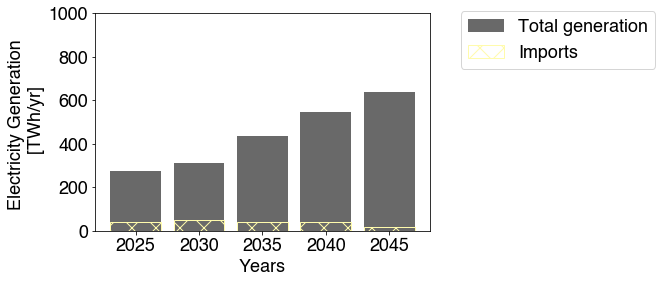

In [112]:
data = pd.read_csv(f"%s/GENERATION.csv" % folder).to_numpy()

imports = data[227-1:238-1,:].copy()

plt.bar(Years, electricity_stack,width = 4,label='Total generation',color ='dimgray')
plt.bar(Years, np.sum(imports,0)/10**6,width = 4,color = "none", alpha = 1, hatch='x', edgecolor = '#FFFBAC',linewidth = 1,label='Imports')
plt.xlabel('Years')
plt.ylabel('Electricity Generation \n [TWh/yr]')
plt.legend(bbox_to_anchor=(1.7, 1.05))

plt.ylim([0,1000])
# fig.savefig(f"Plots/{case_study}/Generation_Imports_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()

## End-Use Appliance Decisions

In [403]:
unique_appliancetypes

array(['GasFiredWH', 'ElecHeatPumpWH', 'GasFurnace_SpaceHeat',
       'ElecHeatPump_SpaceHeat', 'GasRange_Res', 'ElecInduction_Res',
       'GasFiredWHComm', 'ElecHeatPumpWHComm', 'GasFurnace_SpaceHeatComm',
       'ElecHeatPump_SpaceHeatComm', 'AC_GasFurnace',
       'AC_ElecHeatPump_SpaceHeat', 'AC_GasFurnaceComm',
       'AC_HeatPump_SpaceHeatComm'], dtype=object)

<ipython-input-469-1a3b7b5dc4c4>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels)


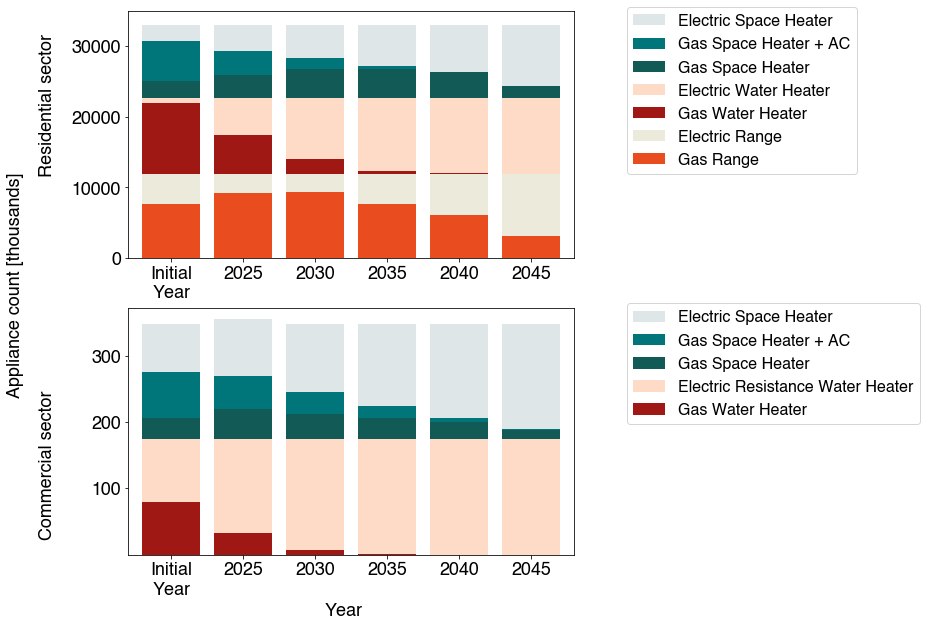

In [469]:
unique_appliancetypes_RES = unique_appliancetypes[[4,5,0,1,2,10,3,11]]
unique_appliancetypes_COMM = unique_appliancetypes[[6,7,8,12,9,13]]

appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")
initial_pop = appliances["Appliance Count [no.]"]/1000
NewYears = np.array([2020,2025,2030,2035,2040,2045])

appliance_labels = ["Gas Range","Electric Range","Gas Water Heater","Electric Water Heater","Gas Space Heater","Gas Space Heater + AC","Electric Space Heater","Electric Space Heater"]
appliance_labels_COMM = ["Gas Water Heater","Electric Resistance Water Heater","Gas Space Heater","Gas Space Heater + AC","Electric Space Heater","Electric Space Heater"]
# appliance_labels = ["Gas Water Heater","Electric Water Heater","Gas Space Heater","Electric Space Heater","Gas Range","Electric Range"]
# appliance_labels_COMM = ["Gas Water Heater","Electric Resistance Water Heater","Gas Space Heater","Electric Space Heater"]
fig, axes = plt.subplots(2, 1, figsize = (8,10), sharex = False, sharey = False)

colors_ResApps = ["#E94C1F","#ECEADA","#A01813","#FDDBC7","#125A56","#00767B","#DEE6E7","#DEE6E7"]
colors_CommApps = ["#A01813","#FDDBC7","#125A56","#00767B","#DEE6E7","#DEE6E7"]

folder = folder1
resources = np.zeros((len(unique_appliancetypes),1))
data = pd.read_csv(f"%s/APPLIANCE_DECISIONS.csv" % folder).to_numpy()
newbuild = np.zeros((len(data[:,0]),T_inv))
premature = np.zeros((len(data[:,0]),T_inv))
totalpop = np.zeros((len(data[:,0]),T_inv))
for k in range(T_inv):
    newbuild[:,k] = data[:,k*3]
    premature[:,k] = data[:,k*3+1]
    totalpop[:,k] = data[:,k*3+2]
newtotalpop = np.zeros((len(data[:,0]),T_inv+1))
newtotalpop[:,0] = initial_pop
newtotalpop[:,1:6] = totalpop

stack = np.zeros((T_inv+1))
for k in range(len(unique_appliancetypes_RES)-1):
    resources = np.sum(newtotalpop[appliances_list == unique_appliancetypes_RES[k],:],0)
    if k == len(unique_appliancetypes_RES) - 2:
        resources += np.sum(newtotalpop[appliances_list == unique_appliancetypes_RES[k+1],:],0)
    axes[0].bar(NewYears, resources,color = colors_ResApps[k],label = appliance_labels[k], bottom = stack, width = 4, align = "center")
        
    stack = stack + resources

stack = np.zeros((T_inv+1))
for k in range(len(unique_appliancetypes_COMM)-1):
    resources = np.sum(newtotalpop[appliances_list == unique_appliancetypes_COMM[k],:],0)
    if k == len(unique_appliancetypes_COMM) - 2:
        resources += np.sum(newtotalpop[appliances_list == unique_appliancetypes_COMM[k+1],:],0)
    axes[1].bar(NewYears, resources,color = colors_CommApps[k],label = appliance_labels_COMM[k], bottom = stack, width = 4, align = "center")

    stack = stack + resources

fig.text(-0.07, 0.5, 'Appliance count [thousands]', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Year', ha='center')
fig.text(-0.015, 0.75, 'Residential sector', ha='center', va='center', rotation='vertical')
fig.text(-0.015, 0.25, 'Commercial sector', ha='center', va='center', rotation='vertical')

for i in range(2):
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.05), loc='upper left', prop={'size': 16})      
    axes[i].set_xlim([2017,2048])
    labels = [0,"Initial\nYear",2025,2030,2035,2040,2045]
    axes[i].set_xticklabels(labels)
axes[0].set_ylim([0,35000])
# fig.savefig(f"Plots/{case_study}/Appliances_Decisions_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()



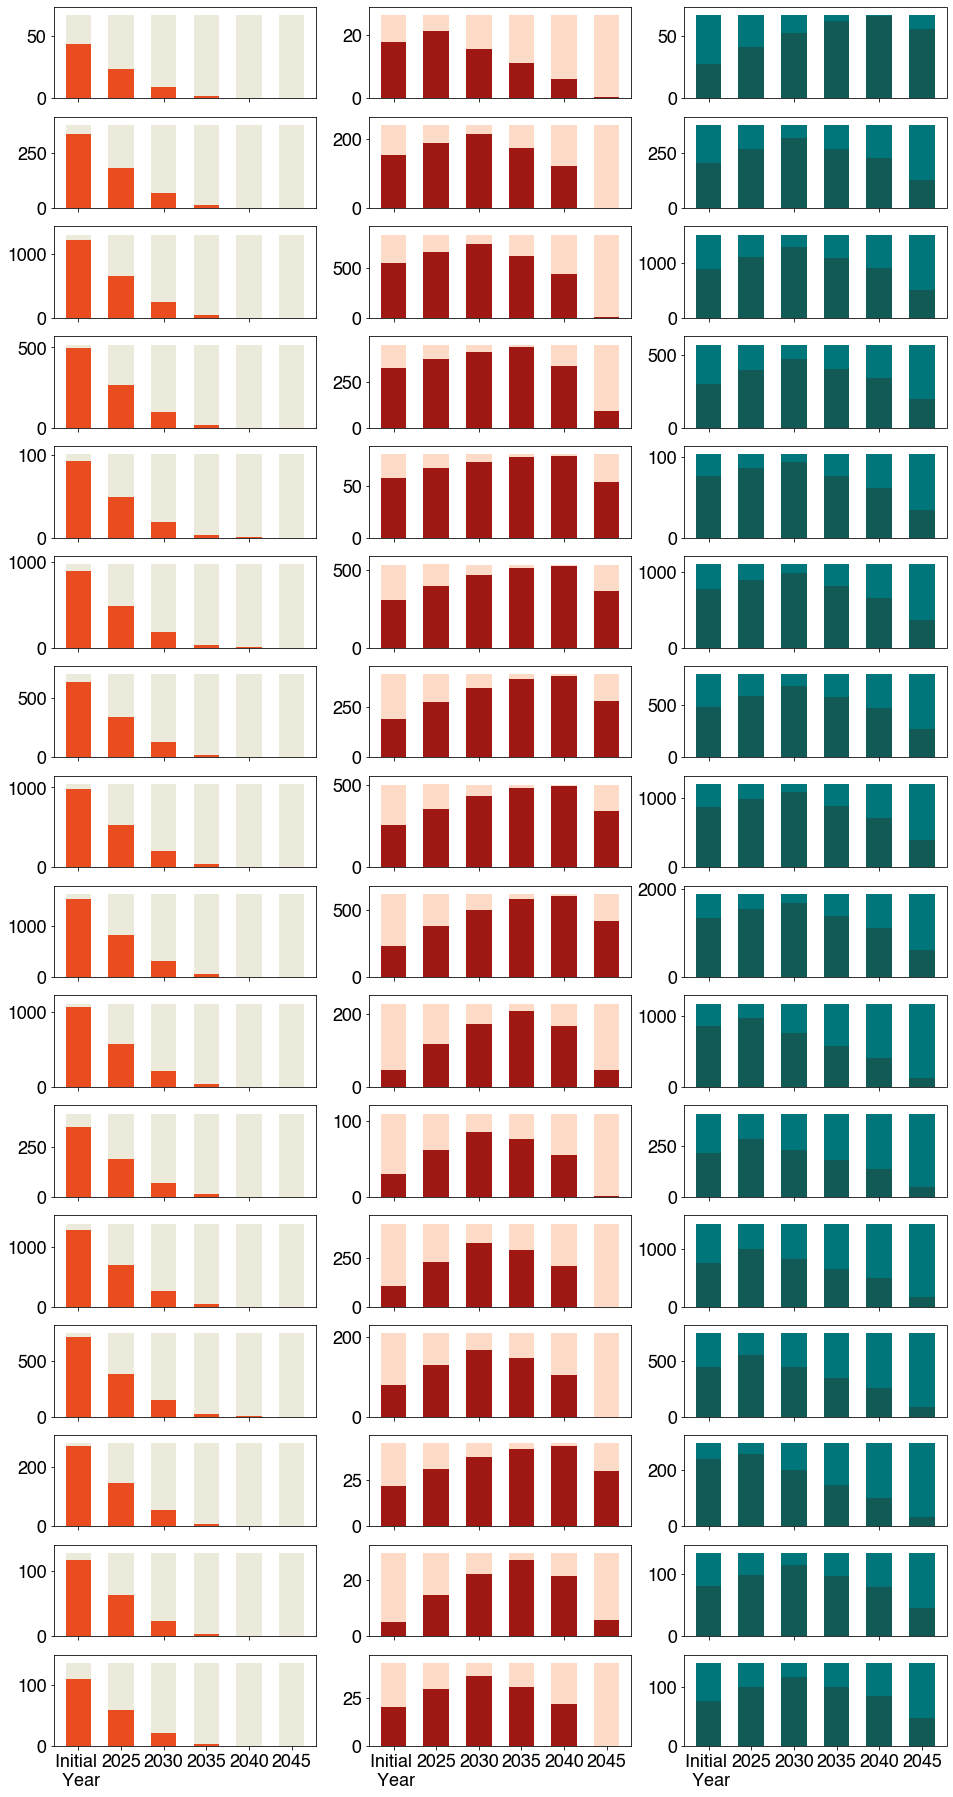

In [470]:
data = newtotalpop

# Define region labels
regions = ['CZ {}'.format(i) for i in range(1, 16)]

# Create a 16x3 grid of subplots for each region
fig, axes = plt.subplots(16, 3, figsize=(16, 32), sharex=False, sharey=False)

appliance_types = ['Water Heater', 'Space Heater', 'Range']
energy_types = ['Gas', 'Electric']
bar_width = 3

for i, appliance_type in enumerate(appliance_types):
    for region_index in range(16):
        ax = axes[region_index, i]  # Select the current subplot
        years = NewYears
        ind = region_index + (i*16*2)
        ind_e = (region_index+16) + (i*16*2)
        gas_data = data[ind]
        electric_data = data[ind_e]
        if appliance_type == appliance_types[0]:
            ic = i+3
            ind = region_index + (ic*16*2)
            ind_e = (region_index+16) + (ic*16*2)
            gas_data += data[ind]
            electric_data += data[ind_e]
        if appliance_type == appliance_types[1]:
            ic = i+3
            ind = region_index + (ic*16*2)
            ind_e = (region_index+16) + (ic*16*2)
            gas_data += data[ind]
            electric_data += data[ind_e]

        # Plot gas and electric separately with legends
        ax.bar(years, gas_data, label=f'Gas {appliance_type}', color=colors_ResApps[i * 2],width = bar_width)
        ax.bar(years, electric_data, label=f'Electric {appliance_type}', bottom=gas_data, color=colors_ResApps[i*2+1], width = bar_width)
        ax.set_ylim(0, np.max(np.sum([gas_data,electric_data],axis = 0))*1.1)
        ax.xaxis.set_ticklabels([])
        if region_index == 15:
            labels = ['Initial \n Year',2025,2030,2035,2040,2045]
            ax.set_xticks(np.arange(2020, 2050, step=5), labels)

# for j in range(2):
#     if j == 0:
#         peak_nodal = np.transpose(pd.read_csv(f"%s/PEAKDEMANDINC.csv" % folder).to_numpy())
#     else:
#         peak_nodal = np.transpose(pd.read_csv(f"%s/PEAKDEMAND.csv" % folder).to_numpy())
#     for region_index in range(16):
#         ax = axes[region_index,3+j] 
#         peak_cz = peak_nodal[region_index,:]
#         original_no = peak_nodal[region_index,0]
#         percent_change = (peak_cz - original_no)/original_no*100
#         ax.plot(Years, percent_change[:], color= 'k',linewidth=2.5)
#         pc = np.around(percent_change[4], decimals = 0)
#         ax.text(0.05,0.6,f'Total Change \n {pc}%', transform=ax.transAxes)
#         ax.xaxis.set_ticklabels([])
#         ax.set_axisbelow(True)
#         ax.grid(color='grey', linestyle='-', linewidth=1,alpha = 0.2)
#         ax.set_xlim([2025,2045])
#         if j == 0:
#             ax.set_yticks(np.arange(0, 1200, step=300))
#         else:
#             ax.set_yticks(np.arange(0,125, step=50))
#         if region_index == 15:
#             labels = [2025,2030,2035,2040,2045]
#             ax.set_xticks(np.arange(2025, 2050, step=5), labels)
#         if j == 0:
#             ax.set_ylim([0,510])
#         else:
#             ax.set_ylim([0,100])

# Show the plots
# fig.savefig(f"Plots/{case_study}/Appliances_Decisions_byRegion_wComm_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()


<ipython-input-316-b22d35c43495>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels)
<ipython-input-316-b22d35c43495>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels)
<ipython-input-316-b22d35c43495>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels)


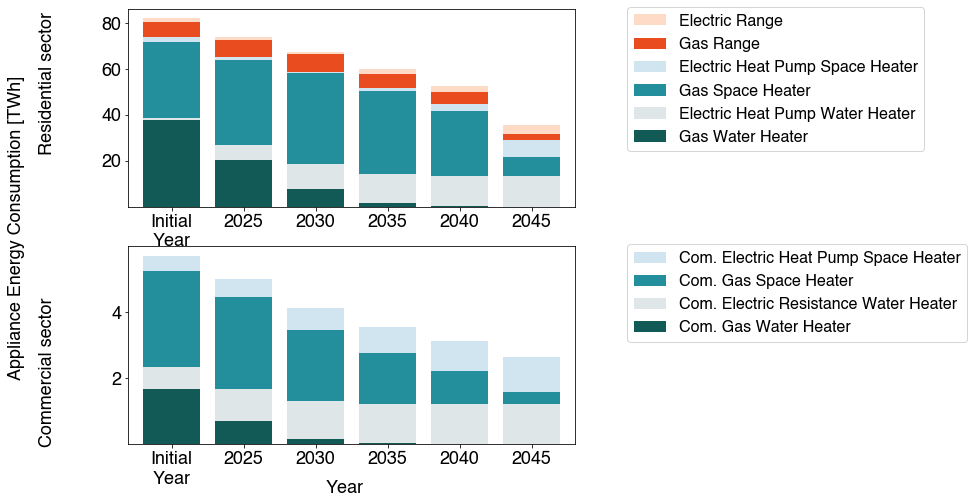

In [316]:
unique_appliancetypes_RES = unique_appliancetypes[0:6]
unique_appliancetypes_COMM = unique_appliancetypes[6:10]

appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")
initial_pop = appliances["Appliance Count [no.]"]/1000
NewYears = np.array([2020,2025,2030,2035,2040,2045])

consumption_elec = np.sum(pd.read_csv("Data/ApplianceProfiles_ELECNetworkCold.csv"), axis=0) # MWh read in
consumption_gas = np.sum(pd.read_csv("Data/ApplianceProfiles_GASNetworkCold.csv"), axis=0)
total_con = consumption_gas+consumption_elec
total_con_reindexed = initial_pop.copy()
total_con_reindexed.values[:] = total_con.values

appliance_labels = ["Gas Water Heater","Electric Heat Pump Water Heater","Gas Space Heater","Electric Heat Pump Space Heater","Gas Range","Electric Range"]
appliance_labels_COMM = ["Com. Gas Water Heater","Com. Electric Resistance Water Heater","Com. Gas Space Heater","Com. Electric Heat Pump Space Heater"]
fig, axes = plt.subplots(2, 1, figsize = (8,8), sharex = False, sharey = False)

folder = folder1
resources = np.zeros((len(unique_appliancetypes),1))
data = pd.read_csv(f"%s/APPLIANCE_DECISIONS.csv" % folder).to_numpy()
newbuild = np.zeros((len(data[:,0]),T_inv))
premature = np.zeros((len(data[:,0]),T_inv))
totalpop = np.zeros((len(data[:,0]),T_inv))
for k in range(T_inv):
    newbuild[:,k] = data[:,k*3]
    premature[:,k] = data[:,k*3+1]
    totalpop[:,k] = data[:,k*3+2]
newtotalpop = np.zeros((len(data[:,0]),T_inv+1))
newtotalpop[:,0] = initial_pop * total_con_reindexed
for m in range(5):
    newtotalpop[:,m+1] = totalpop[:,m] * total_con_reindexed

stack = np.zeros((T_inv+1))
for k in range(len(unique_appliancetypes_RES)):
    resources = np.sum(newtotalpop[appliances_list == unique_appliancetypes_RES[k],:],0)/1000 # convert to TWh
    axes[0].bar(NewYears, resources,color = colors_ResApps[k],label = appliance_labels[k], bottom = stack, width = 4, align = "center")
        
    stack = stack + resources

stack = np.zeros((T_inv+1))
for k in range(len(unique_appliancetypes_COMM)):
    resources = np.sum(newtotalpop[appliances_list == unique_appliancetypes_COMM[k],:],0)/1000 # convert to TWh
    axes[1].bar(NewYears, resources,color = colors_CommApps[k],label = appliance_labels_COMM[k], bottom = stack, width = 4, align = "center")

    stack = stack + resources

for i in range(2):
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.05), loc='upper left', prop={'size': 16})      
    axes[i].set_xlim([2017,2048])
    labels = [0,"Initial\nYear",2025,2030,2035,2040,2045]
    axes[i].set_xticklabels(labels)

fig.text(-0.07, 0.5, 'Appliance Energy Consumption [TWh]', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Year', ha='center')
fig.text(-0.015, 0.75, 'Residential sector', ha='center', va='center', rotation='vertical')
fig.text(-0.015, 0.25, 'Commercial sector', ha='center', va='center', rotation='vertical')

labels = [0,"Initial\nYear",2025,2030,2035,2040,2045]
axes[0].set_xticklabels(labels)
axes[1].set_xticklabels(labels)

# fig.savefig(f"Plots/{case_study}/Appliances_Consumption_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()



<ipython-input-271-55807338a190>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels)


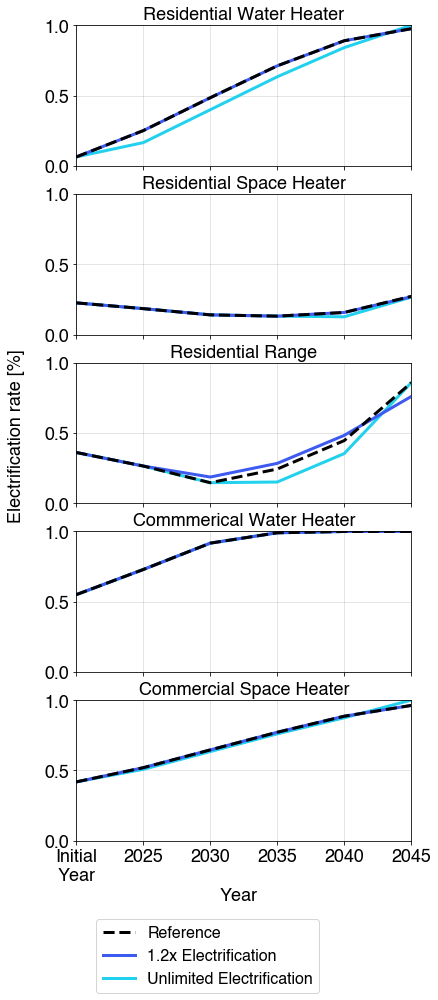

In [271]:
unique_appliancetypes_RES = unique_appliancetypes[0:6]
unique_appliancetypes_COMM = unique_appliancetypes[6:10]

appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")
initial_pop = appliances["Appliance Count [no.]"]/1000
NewYears = np.array([2020,2025,2030,2035,2040,2045])

appliance_labels = ["Gas Water Heater","Electric Heat Pump Water Heater","Gas Space Heater","Electric Heat Pump Space Heater","Gas Range","Electric Range"]
appliance_labels_COMM = ["Com. Gas Water Heater","Com. Electric Resistance Water Heater","Com. Gas Space Heater","Com. Electric Heat Pump Space Heater"]
fig, axes = plt.subplots(5, 1, figsize = (6,15), sharex = False, sharey = False)

# colors1 = ["black","#EB2A5D","#FFB44B"]
# casename = ["Reference","20% Offsets","50% Offsets"]
# folderX = ["Core/Output/Default","Core/Output/Offsets 20","Core/Output/Offsets 50"]
# colors1 = ["black","#EB2A5D","#FFB44B"]
# casename = ["Reference","Low App","High App"]
# folderX = ["Core/Output/Default","Core/Output/Low App","Core/Output/High App 2"]
# colors1 = ["black","#17594A","#D3D04F"]
# casename = ["Reference","20% H$_2$ Blend", "50% H$_2$ Blend"]
# folderX = ["Core/Output/Default","Core/Output/H2 20", "Core/Output/H2 50"]
# colors1 = ["black","#504077","#FF6868"]
# casename = ["Reference","No Transmission", "Unlimited, No Cost Transmission"]
# folderX = ["Core/Output/Default","Core/Output/Trans No", "Core/Output/Trans Unl"]
colors1 = ["black","#3D5AF1","#22D1EE"]
casename = ["Reference","1.2x Electrification", "Unlimited Electrification"]
folderX = ["Core/Output/Default","Core/Output/App 12", "Core/Output/App Unl"]

for i in [2,1,0]:
    resources = np.zeros((len(unique_appliancetypes),1))
    data = pd.read_csv(f"%s/APPLIANCE_DECISIONS.csv" % folderX[i]).to_numpy()
    newbuild = np.zeros((len(data[:,0]),T_inv))
    premature = np.zeros((len(data[:,0]),T_inv))
    totalpop = np.zeros((len(data[:,0]),T_inv))
    for k in range(T_inv):
        newbuild[:,k] = data[:,k*3]
        premature[:,k] = data[:,k*3+1]
        totalpop[:,k] = data[:,k*3+2]
    newtotalpop = np.zeros((len(data[:,0]),T_inv+1))
    newtotalpop[:,0] = initial_pop
    newtotalpop[:,1:6] = totalpop
    
    stack = np.zeros((T_inv+1))
    
    gaswh = np.sum(newtotalpop[appliances_list == unique_appliancetypes_RES[0],:],0)
    elecwh = np.sum(newtotalpop[appliances_list == unique_appliancetypes_RES[1],:],0)
    gassh = np.sum(newtotalpop[appliances_list == unique_appliancetypes_RES[2],:],0)
    elecsh = np.sum(newtotalpop[appliances_list == unique_appliancetypes_RES[3],:],0)
    gasck = np.sum(newtotalpop[appliances_list == unique_appliancetypes_RES[4],:],0)
    elecck = np.sum(newtotalpop[appliances_list == unique_appliancetypes_RES[5],:],0)
    gaswhC = np.sum(newtotalpop[appliances_list == unique_appliancetypes_COMM[0],:],0)
    elecwhC = np.sum(newtotalpop[appliances_list == unique_appliancetypes_COMM[1],:],0)
    gasshC = np.sum(newtotalpop[appliances_list == unique_appliancetypes_COMM[2],:],0)
    elecshC = np.sum(newtotalpop[appliances_list == unique_appliancetypes_COMM[3],:],0)
    
    linewidth = 3
    linestyle = '-'
    if casename[i] == "Reference":
        linestyle = 'dashed'
    axes[0].plot(NewYears, elecwh/(elecwh+gaswh),color = colors1[i],label = casename[i],lw=linewidth,ls=linestyle)
    axes[1].plot(NewYears, elecsh/(elecsh+gassh),color = colors1[i],label = casename[i],lw=linewidth,ls=linestyle)
    axes[2].plot(NewYears, elecck/(elecck+gasck),color = colors1[i],label = casename[i],lw=linewidth,ls=linestyle)
    axes[3].plot(NewYears, elecwhC/(elecwhC+gaswhC),color = colors1[i],label = casename[i],lw=linewidth,ls=linestyle)
    axes[4].plot(NewYears, elecshC/(elecshC+gasshC),color = colors1[i],label = casename[i],lw=linewidth,ls=linestyle)
            
for i in range(5): 
    axes[i].set_ylim([0,1.0])
    if i < 4:
        axes[i].xaxis.set_ticklabels([])
    else: 
        labels = ["Initial\nYear",2025,2030,2035,2040,2045]
        axes[i].set_xticklabels(labels)  
handles, labels = axes[4].get_legend_handles_labels()
axes[4].legend(handles[::-1], labels[::-1], bbox_to_anchor=(0.75, -0.5), prop={'size': 16})   
fig.text(-0.015, 0.5, 'Electrification rate [%]', ha='center', va='center', rotation='vertical')
axes[0].set_title('Residential Water Heater',fontsize = 18)
axes[1].set_title('Residential Space Heater',fontsize = 18)
axes[2].set_title('Residential Range',fontsize = 18)
axes[3].set_title('Commmerical Water Heater',fontsize = 18)
axes[4].set_title('Commercial Space Heater',fontsize = 18)

for i in range(5):
    axes[i].set_xlim([2020,2045])
    axes[i].set_axisbelow(True)
    axes[i].grid(color='grey', linestyle='-', linewidth=1,alpha = 0.2)
fig.text(0.5, 0.07, 'Year', ha='center',fontsize = 18)

# fig.savefig(f"Plots/{case_study}/Appliances_Electrification_{casename[1]}_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()



## Representative Days Heatmap

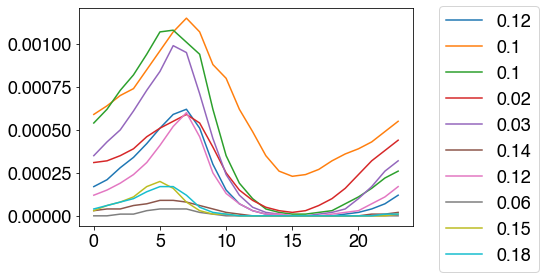

[0.62 1.15 1.08 0.59 0.99 0.09 0.6  0.04 0.2  0.17]


In [24]:
repdays = pd.read_csv(f"%s/REPDAYS.csv" % folder).to_numpy()
medoid = [39.0, 356.0, 324.0, 334.0, 316.0, 237.0, 41.0, 217.0, 172.0, 241.0]
num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
weights = [0.11506849315068493, 0.0958904109589041, 0.09863013698630137, 0.024657534246575342, 0.030136986301369864, 0.136986301369863, 0.11506849315068493, 0.06301369863013699, 0.14520547945205478, 0.17534246575342466]

sh_profile = pd.read_csv("Data/ApplianceProfiles_ELECNetworkCold.csv")
sh_cz3 = sh_profile["x50"]
np.shape(sh_cz3)

mat = np.zeros((len(medoid), 24),float)
peak = np.zeros((len(medoid)),float)
for i in range(len(medoid)):
    day = int(medoid[i])
    profile = sh_cz3[(day-1)*24:(day)*24]
    peak[i] = max(profile)
    mat[i,:] = profile
    plt.plot(mat[i,:],label = round(weights[i],2))

plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()
print(peak*1000)
new_ARR = repdays[:,0]* 0
sorted_val = [6,9,10,7,8,2,5,1,4,3]
for i in range(len(peak)):
    mask = (repdays[:,0] == i+1)
    indices = np.where(mask)
    new_ARR[indices] = sorted_val[i]

with open("core/Output/REPDAYS_ORDERED_10.csv", 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow("C")
    for value in new_ARR:
        writer.writerow([value])

In [25]:
DAYS = ['Sun.', 'Mon.', 'Tues.', 'Wed.', 'Thurs.', 'Fri.', 'Sat.']
MONTHS = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']


def date_heatmap(series, start=None, end=None, mean=False, ax=None, **kwargs):
    '''Plot a calendar heatmap given a datetime series.

    Arguments:
        series (pd.Series):
            A series of numeric values with a datetime index. Values occurring
            on the same day are combined by sum.
        start (Any):
            The first day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            earliest date in the data.
        end (Any):
            The last day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            latest date in the data.
        mean (bool):
            Combine values occurring on the same day by mean instead of sum.
        ax (matplotlib.Axes or None):
            The axes on which to draw the heatmap. The default is the current
            axes in the :module:`~matplotlib.pyplot` API.
        **kwargs:
            Forwarded to :meth:`~matplotlib.Axes.pcolormesh` for drawing the
            heatmap.

    Returns:
        matplotlib.collections.Axes:
            The axes on which the heatmap was drawn. This is set as the current
            axes in the `~matplotlib.pyplot` API.
    '''
    # Combine values occurring on the same day.
    dates = series.index.floor('D')
    group = series.groupby(dates)
    series = group.mean() if mean else group.sum()

    # Parse start/end, defaulting to the min/max of the index.
    start = pd.to_datetime(start or series.index.min())
    end = pd.to_datetime(end or series.index.max())

    # We use [start, end) as a half-open interval below.
    end += np.timedelta64(1, 'D')

    # Get the previous/following Sunday to start/end.
    # Pandas and numpy day-of-week conventions are Monday=0 and Sunday=6.
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun = end + np.timedelta64(7 - end.dayofweek - 1, 'D')

    # Create the heatmap and track ticks.
    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.zeros((7, num_weeks))
    ticks = {}  # week number -> month name
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date < end:
                heatmap[day, week] = series.get(date, 0)

    # Get the coordinates, offset by 0.5 to align the ticks.
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5

    # Plot the heatmap. Prefer pcolormesh over imshow so that the figure can be
    # vectorized when saved to a compatible format. We must invert the axis for
    # pcolormesh, but not for imshow, so that it reads top-bottom, left-right.
    ax = ax or plt.gca()
    mesh = ax.pcolormesh(x, y, heatmap, **kwargs)
    ax.invert_yaxis()

    # Set the ticks.
    ax.set_xticks(list(ticks.keys()))
    ax.set_xticklabels(list(ticks.values()))
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(DAYS)

    # Set the current image and axes in the pyplot API.
    plt.sca(ax)
    plt.sci(mesh)

    return ax


def date_heatmap_demo(filename,no_repday,plot):
    '''An example for `date_heatmap`.

    Most of the sizes here are chosen arbitrarily to look nice with 1yr of
    data. You may need to fiddle with the numbers to look right on other data.
    '''
    # Get some data, a series of values with datetime index.
    # data = pd.read_csv(f"%s/{filename}.csv" % folder).to_numpy()
    data = pd.read_csv(f"core/Output/{filename}.csv").to_numpy()
    data = pd.Series(data[:,0])
    # data = np.random.randint(5, size=365)
    # data = pd.Series(data)
    data.index = pd.date_range(start='2018-01-01', end='2018-12-31', freq='1D')

    # Create the figure. For the aspect ratio, one year is 7 days by 53 weeks.
    # We widen it further to account for the tick labels and color bar.
    figsize = plt.figaspect(7 / 56)
    fig = plt.figure(figsize=figsize)

    # Plot the heatmap with a color bar.
    ax = date_heatmap(data, edgecolor='black')
    # plt.colorbar(ticks=range(6), pad=0.02, label='Rep. Day')
    plt.colorbar(ticks=range(no_repday+1), pad=0.02, label='Rep. Day')

    # Use a discrete color map with 5 colors (the data ranges from 0 to 4).
    # Extending the color limits by 0.5 aligns the ticks in the color bar.
    # cmap = plt.cm.get_cmap('Blues', 5)
    # plt.set_cmap(cmap)
    # plt.clim(0.5, 5.5)
    cmap = plt.cm.get_cmap('RdYlBu', no_repday)
    plt.set_cmap(cmap)
    plt.clim(0.5, no_repday+0.5)

    # Force the cells to be square. If this is set, the size of the color bar
    # may look weird compared to the size of the heatmap. That can be corrected
    # by the aspect ratio of the figure or scale of the color bar.
    ax.set_aspect('equal')
    plt.show()

    # Save to a file. For embedding in a LaTeX doc, consider the PDF backend.
    # http://sbillaudelle.de/2015/02/23/seamlessly-embedding-matplotlib-output-into-latex.html
    if plot == 1:
        fig.savefig(f"Plots/Validation/RepDays_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)

    # The firgure must be explicitly closed if it was not shown.
    # plt.close(fig)



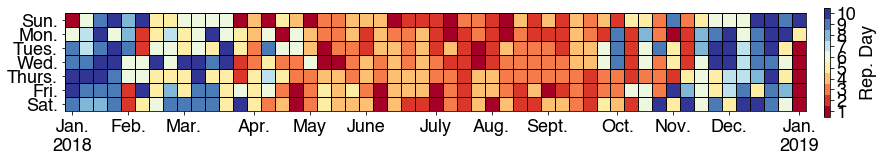

In [26]:
date_heatmap_demo("REPDAYS_ORDERED_10",10,1)

## Hourly Dispatch

3744 3912
-2.2162387206913565e-05
872.2231430360277
571.030358183455


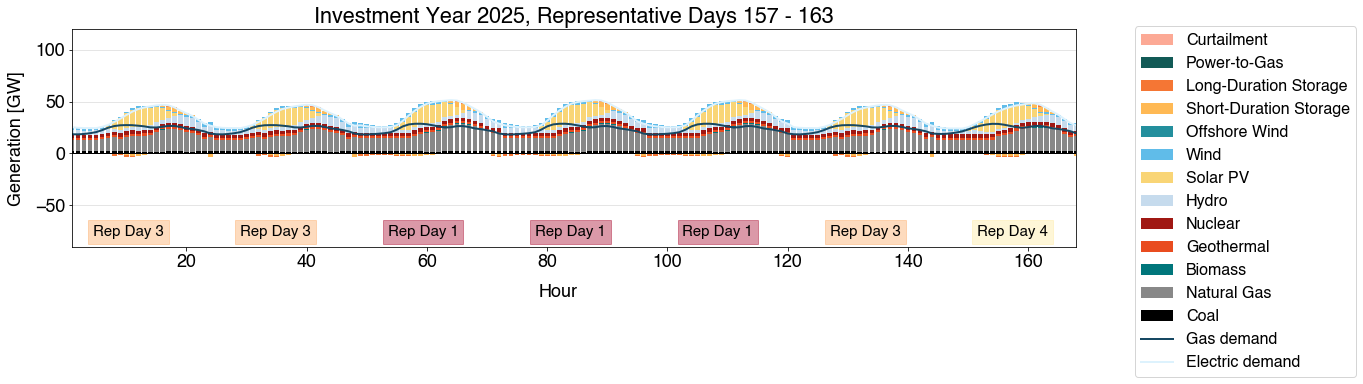

12504 12672
-53.04154175604447
882.3477264360545
539.2889682255618


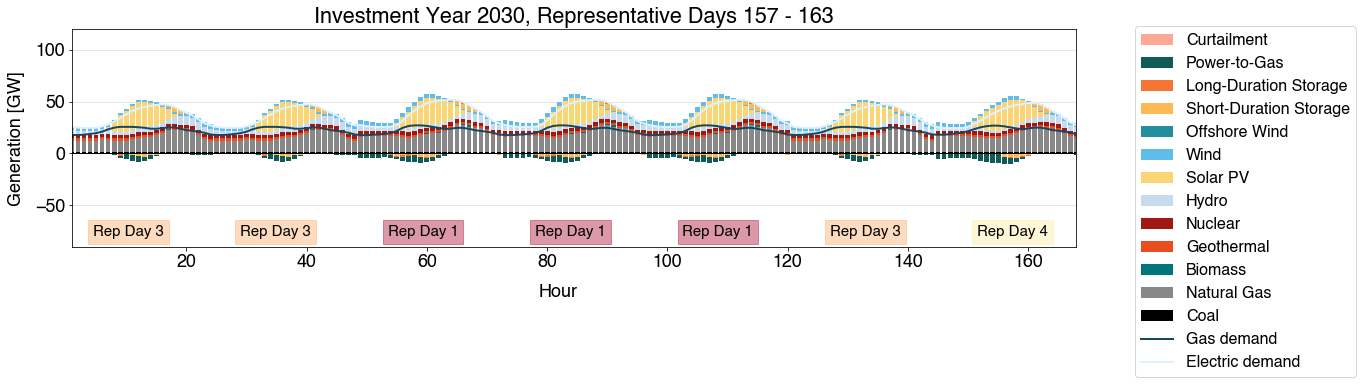

21264 21432
-348.5489566696662
889.4782342232348
518.7547074585838


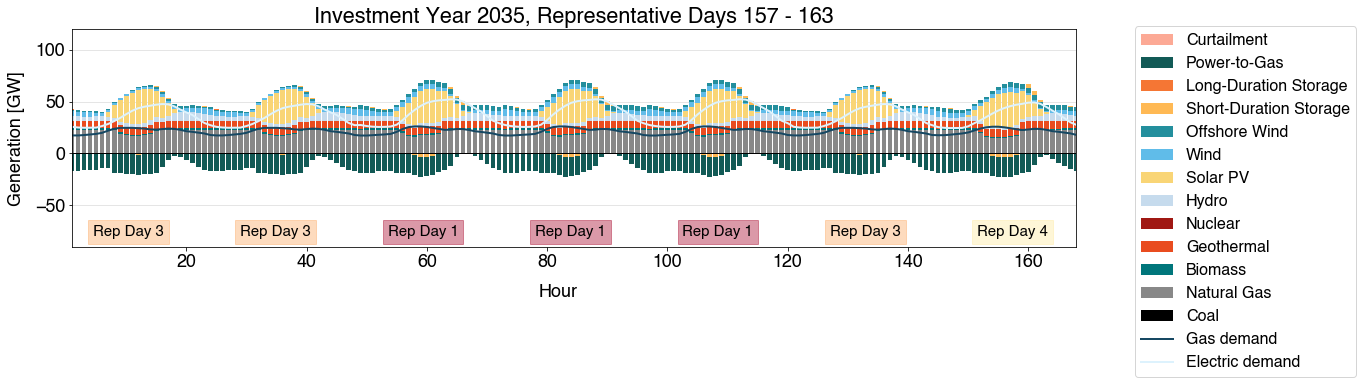

30024 30192
-648.5273507876367
892.4080099020211
510.99216983055857


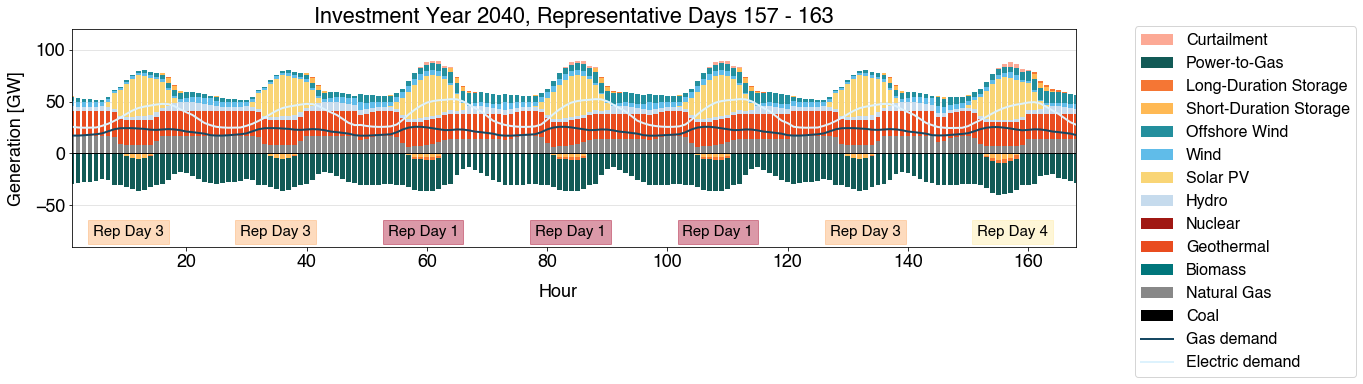

38784 38952
-896.0423960535187
896.2389020209478
501.78284821888155


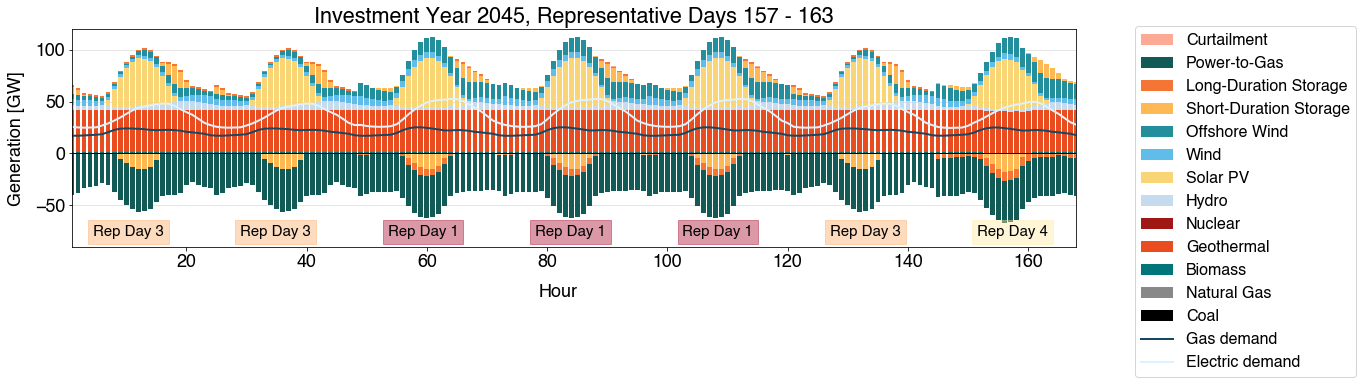

In [524]:
# resource_list_hourly = (np.append(np.append(generators["Prime Mover"].to_numpy(), storage_elec["Prime Mover"].to_numpy()), p2g["Prime Mover"].to_numpy()))
# resource_list_hourly = np.where(resource_list_hourly == "Net-zero CH4", "Electro-methane",resource_list_hourly)
# unique_resources_P2G = np.where(unique_resources_P2G == "Net-zero CH4", "Electro-methane",unique_resources_P2G)
# unique_resources_hourly = (np.append(np.append(generators["Prime Mover"].drop_duplicates().to_numpy(), storage_elec["Prime Mover"].drop_duplicates().to_numpy()), p2g["Prime Mover"].drop_duplicates().to_numpy()))
# unique_resources_hourly = np.where(unique_resources_hourly == "Net-zero CH4", "Electro-methane",unique_resources_hourly)
resource_list_hourly = resource_list[:518]
unique_resources_hourly = unique_resources
unique_resources_P2G = np.array(['Power-to-Gas'])
unique_resources_STORAGE = np.array(['Short-Duration Storage', 'Long-Duration Storage'])
colors_STORAGE = colors[-3:-1]

repday = pd.read_csv(f"core/Output/REPDAYS_ordered_10.csv").to_numpy()
repday = pd.Series(repday[:,0]).astype(int)

d = 7
nn = -5
iit = 1 # yr for comparison
appliance_cases = np.array([case1])

dataX = pd.read_csv(f"%s/HOURLY_GENERATION.csv" % folder).to_numpy()
data2X = pd.read_csv(f"%s/HOURLY_LOAD.csv" % folder).to_numpy()

all_yr = [0,1,2,3,4]
# all_yr = [0,2,4]
for yr in all_yr:
    fig, axes = plt.subplots(1, 1, figsize = (18,4), sharex = True, sharey = True)
    for i in range(len(appliance_cases)):
        folder = folder1
        stack = np.zeros((d*24))
        
        if i == 0:
            cd = 156

        data = dataX[0:-1,int(yr*8760 + (cd)*24):int(yr*8760 + (cd)*24 + d*24)]/1000
        data2 = data2X[:,int(yr*8760 + (cd)*24):int(yr*8760 + (cd)*24 + d*24)]/1000
        print(int(yr*8760 + (cd)*24),int(yr*8760 + (cd)*24 + d*24))

        for k in range(len(unique_resources_GEN)):
            resources = np.maximum(np.sum(data[resource_list_hourly == unique_resources_GEN[k]],0),0)
            axes.bar(np.linspace(1,d*24,d*24), resources[0:d*24], label = unique_resources_GEN[k],color = colors_GEN[k],  bottom = stack)
            stack = stack + resources[0:d*24]
        stack_plus = stack.copy()
        stack_minus = np.zeros(np.shape(stack))
        for k in range(len(unique_resources_STORAGE)):
            resources_minus = -1*np.maximum(np.sum(data[resource_list_hourly == unique_resources_STORAGE[k]],0),0)
            resources_plus = -1*np.minimum(np.sum(data[resource_list_hourly == unique_resources_STORAGE[k]],0),0)
            axes.bar(np.linspace(1,d*24,d*24), resources_plus[0:d*24], label = unique_resources_STORAGE[k],color = colors_STORAGE[k], bottom = stack_plus)
            axes.bar(np.linspace(1,d*24,d*24), resources_minus[0:d*24],color = colors_STORAGE[k],  bottom = stack_minus)
            stack_plus = stack_plus.copy() + resources_plus[0:d*24]
            stack_minus = stack_minus.copy() + resources_minus[0:d*24]
        p2g_minus = np.zeros(np.shape(stack))
        for k in range(len(unique_resources_P2G)):
            resources_minus = -1*np.maximum(np.sum(data[resource_list_hourly == unique_resources_P2G[k]],0),0)
            axes.bar(np.linspace(1,d*24,d*24), resources_minus[0:d*24], label = unique_resources_P2G[k], color = colors_P2G[k],bottom = stack_minus)
            stack_minus = stack_minus.copy() + resources_minus[0:d*24]
            p2g_minus += resources_minus[0:d*24]
        print(np.sum(p2g_minus)/7)
        axes.bar(np.linspace(1,d*24,d*24), np.minimum((data2[0,0:d*24]-stack_minus)-stack_plus,0), color = "#FCA995", label = "Curtailment", bottom = stack_plus)

        # axes.plot(np.linspace(1,d*24,d*24), data2[2,0:d*24], label = 'Baseline load', linewidth = 2, color = "firebrick")
        axes.plot(np.linspace(1,d*24,d*24), data2[0,0:d*24], label = 'Electric demand', linewidth = 2, color = '#DDF2FD')
        axes.plot(np.linspace(1,d*24,d*24), data2[1,0:d*24], label = 'Gas demand', linewidth = 2, color = "#164863")

        print(np.sum(data2[0,0:d*24])/7)
        print(np.sum(data2[1,0:d*24])/7)

        axes.axhline(linewidth=1, color='k')
        axes.set_xlim([1,d*24])
        axes.set_ylim([-90,120])
        axes.set_title(f'Investment Year {2025+yr*5}, Representative Days {cd+1} - {cd+1+6}')
        st = 4.5
        dis = 24.5
        cmap = plt.cm.get_cmap('RdYlBu', 8)
        for m in range(7):
            axes.text(st+dis*m, -80, f'Rep Day {repday[cd+m]}', fontsize = 15,bbox = dict(facecolor = cmap(repday[cd+m]-1), alpha = 0.4,edgecolor=cmap(repday[cd+m]-1), pad=5.0))
        axes.set_axisbelow(True)
        axes.grid(color='grey', linestyle='-', linewidth=1,alpha = 0.2,axis='y')

    handles, labels = axes.get_legend_handles_labels()
    # labels = np.where(np.array(labels) == "Electrolysis","Electrolytic hydrogen",np.array(labels))
    axes.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1.05), loc='upper left', prop={'size': 16},ncol=1)
    fig.text(0.5, -0.05, 'Hour', ha='center')
    fig.text(0.075, 0.5, 'Generation [GW]', va='center', rotation='vertical')
    # fig.savefig(f"Plots/{case_study}/Hourly_Dispatch_{yr+1}_{cd}_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
    plt.show()


## Validation of Dispatch

In [18]:
unique_resources = np.array(['Coal', 'Natural Gas CC', 'Natural Gas CT', 'Natural Gas CC-CCS', 
    'Nuclear', 'Geothermal', 'Geothermal EGS', 'Hydropower', 
    'Biopower','Wind','OffshoreWind', 
    'Solar PV', 'Comm Solar PV','Res Solar PV','Solar Thermal',
    'Li-ion battery','Long-duration storage','Underground gas storage',
    'Biomethane','Electro-methane','Electrolysis'])
unique_resources_genss = np.array(['Coal', 'Nuclear', 'Geothermal','Natural Gas CC', 'Natural Gas CT', 'Natural Gas CC-CCS', 
    'Hydropower', 
    'Biopower','Wind',
    'Solar PV', 'Comm Solar PV','Res Solar PV','Solar Thermal'])
colors_gens = np.array(['black', '#FF6868','#924992','dimgray', 'gainsboro',
    '#4E6E81',
    '#96B6C5', '#22D1EE','#FFEB7D'])
colors_genss = np.array(['black', '#FF6868','#924992','dimgray', 'dimgray', 'dimgray',
    '#4E6E81',
    '#96B6C5', '#22D1EE',
    '#FFEB7D', '#FFEB7D', '#FFEB7D','#FFEB7D'])

8232 8400


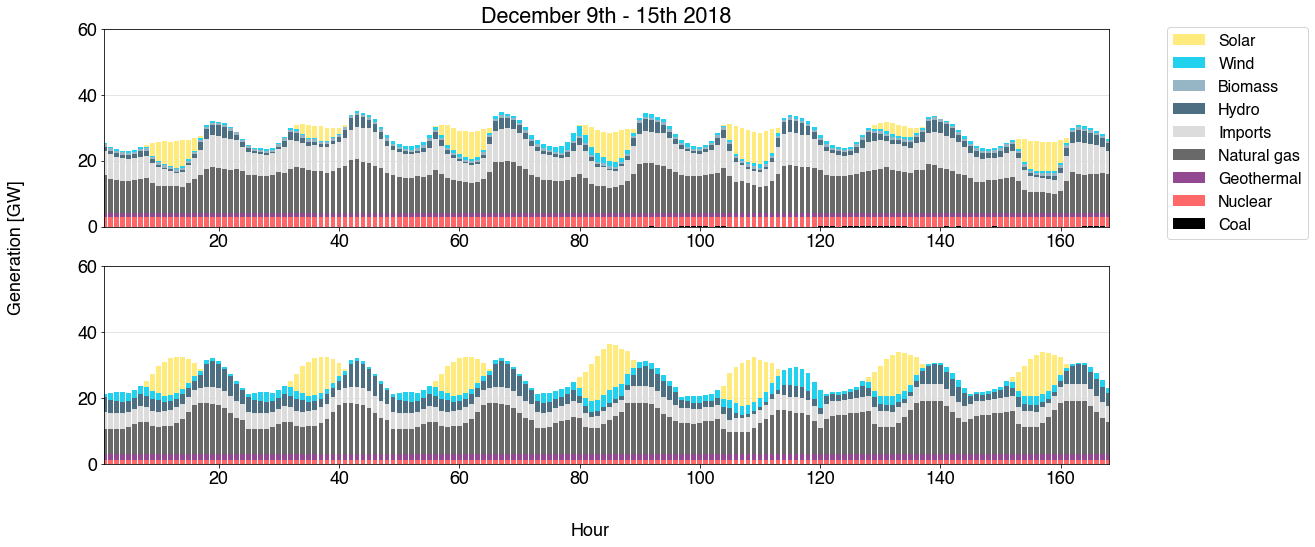

In [29]:
dec_dispatch = pd.read_csv("Plots/Validation/Dec Dispatch.csv")
jul_dispatch = pd.read_csv("Plots/Validation/July Dispatch.csv")

resource_list_hourly = (np.append(np.append(generators["Prime Mover"].to_numpy(), storage_elec["Prime Mover"].to_numpy()), p2g["Prime Mover"].to_numpy()))
resource_list_hourly = np.where(resource_list_hourly == "Net-zero CH4", "Electro-methane",resource_list_hourly)
unique_resources_P2G = np.where(unique_resources_P2G == "Net-zero CH4", "Electro-methane",unique_resources_P2G)
unique_resources_hourly = (np.append(np.append(generators["Prime Mover"].drop_duplicates().to_numpy(), storage_elec["Prime Mover"].drop_duplicates().to_numpy()), p2g["Prime Mover"].drop_duplicates().to_numpy()))
unique_resources_hourly = np.where(unique_resources_hourly == "Net-zero CH4", "Electro-methane",unique_resources_hourly)

repday = pd.read_csv(f"core/Output/REPDAYS_ordered_10.csv").to_numpy()
repday = pd.Series(repday[:,0]).astype(int)

d = 7
nn = -5
iit = 1 # yr for comparison
appliance_cases = np.array([case1])

dataX = pd.read_csv(f"%s/HOURLY_GENERATION.csv" % folder).to_numpy()
data2X = pd.read_csv(f"%s/HOURLY_LOAD.csv" % folder).to_numpy()

all_yr = [0,1,2,3,4]
all_yr = [0]
cd = 200
cd = 343
for yr in all_yr:
    fig, ax = plt.subplots(2, 1, figsize = (18,8), sharex = False, sharey = True)
    stack = np.zeros((d*24))
    gens = ["Coal","Nuclear", "Geothermal", "Natural gas", "Imports", "Hydro", "Biomass", "Wind", "Solar"]
    for m in range(len(gens)):
        axes = ax[0]
        dispatch = dec_dispatch
        axes.bar(np.linspace(1,d*24,d*24),dispatch[gens[m]][1::12],bottom = stack,label = gens[m],color = colors_gens[m])
        stack = stack + dispatch[gens[m]][1::12]
    
    for i in range(len(appliance_cases)):
        folder = folder1
        stack = np.zeros((d*24))

        axes = ax[1]
        data = dataX[0:237-11,int(yr*8760 + (cd)*24):int(yr*8760 + (cd)*24 + d*24)]/1000
        dataimport =dataX[237-11:237,int(yr*8760 + (cd)*24):int(yr*8760 + (cd)*24 + d*24)]/1000
        print(int(yr*8760 + (cd)*24),int(yr*8760 + (cd)*24 + d*24))

        for k in range(len(unique_resources_genss)):
            if k == 6:
                resources = np.maximum(np.sum(dataimport,0),0)
                axes.bar(np.linspace(1,d*24,d*24), resources[0:d*24], label = "Imports",color = colors_gens[4],  bottom = stack)
                stack = stack + resources[0:d*24]
            resources = np.maximum(np.sum(data[resource_list_hourly[0:237-11] == unique_resources_genss[k]],0),0)
            axes.bar(np.linspace(1,d*24,d*24), resources[0:d*24], label = unique_resources_genss[k],color = colors_genss[k],  bottom = stack)
            stack = stack + resources[0:d*24]
        
        ax[0].axhline(linewidth=1, color='k')
        ax[1].axhline(linewidth=1, color='k')
        ax[0].set_xlim([1,d*24])
        ax[1].set_xlim([1,d*24])
        axes.set_ylim([0,60])
        if cd == 200:
            ax[0].set_title(f'July 19th - 25th 2018')
            # ax[1].set_title(f'BRIDGES July 19th - 25th 2018')
        else:
            ax[0].set_title(f'December 9th - 15th 2018')
            # ax[1].set_title(f'BRIDGES December 9th - 15th 2018')
        ax[0].set_axisbelow(True)
        ax[1].set_axisbelow(True)
        ax[0].grid(color='grey', linestyle='-', linewidth=1,alpha = 0.2,axis='y')
        ax[1].grid(color='grey', linestyle='-', linewidth=1,alpha = 0.2,axis='y')

    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1.05), loc='upper left', prop={'size': 16},ncol=1)
    fig.text(0.5, 0.0, 'Hour', ha='center')
    fig.text(0.05, 0.5, 'Generation [GW]', va='center', rotation='vertical')
    fig.savefig(f"Plots/Validation/Validation - December.png",bbox_inches = "tight", dpi = 300)
    # fig.savefig(f"Plots/{case_study}/Hourly_Dispatch_{yr+1}_{cd}_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
    plt.show()


4560 4728


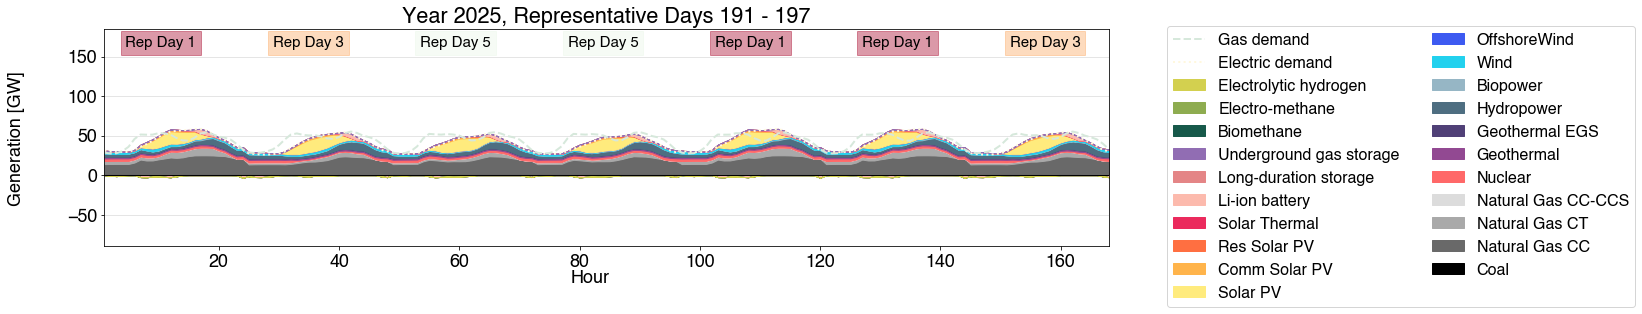

13320 13488


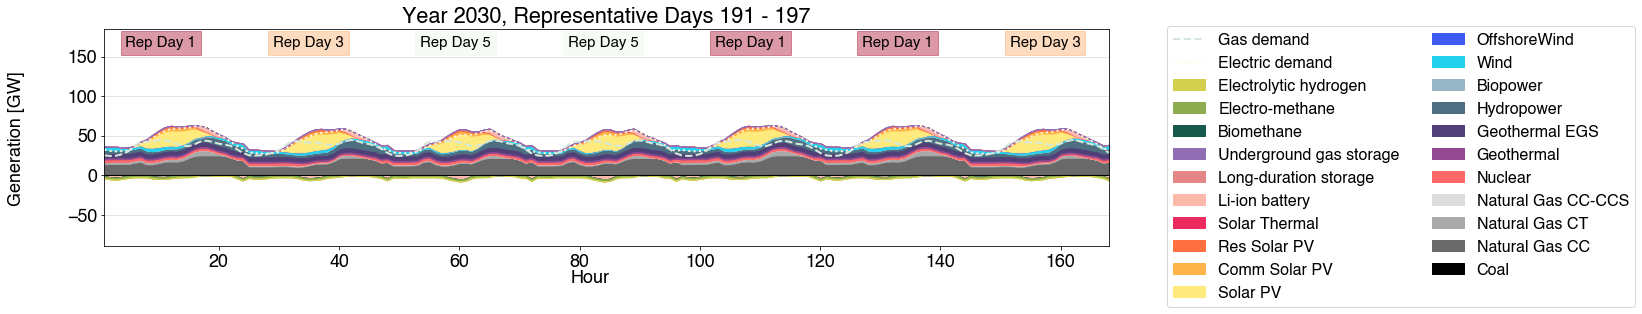

22080 22248


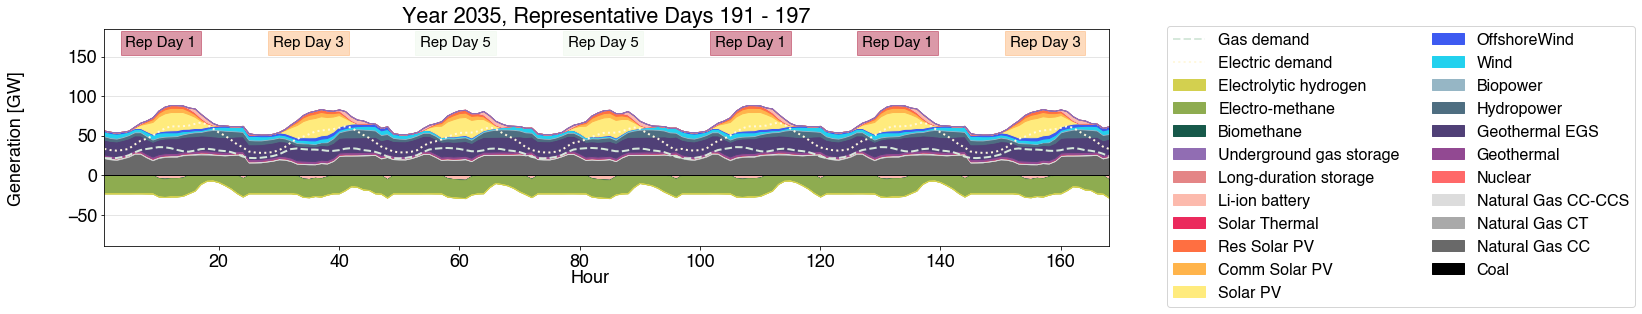

30840 31008


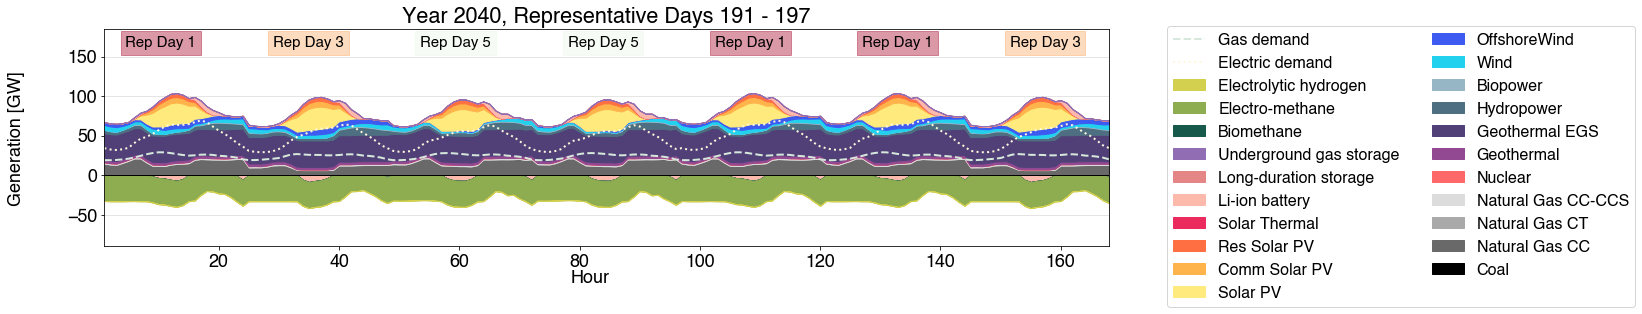

39600 39768


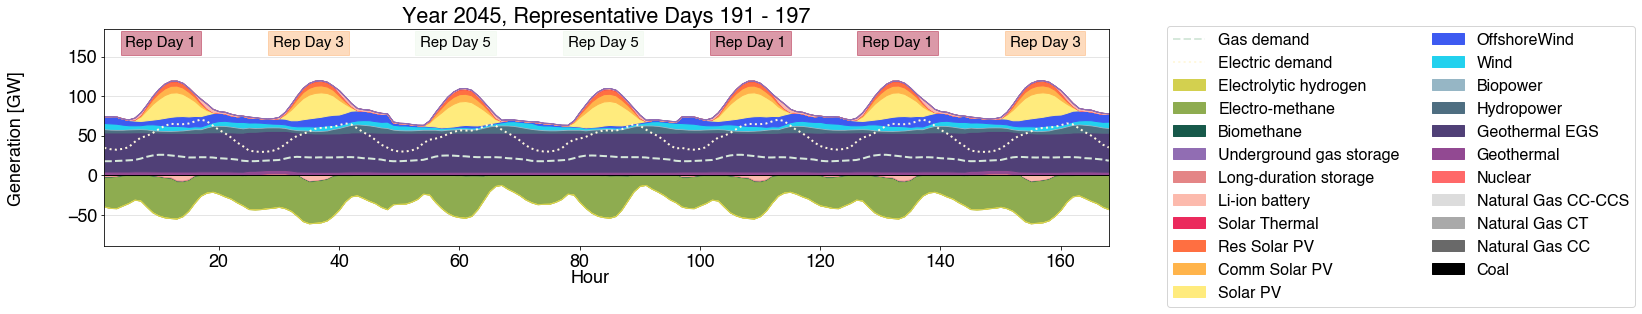

In [305]:
# resource_list_hourly = (np.append(np.append(generators["Prime Mover"].to_numpy(), storage_elec["Prime Mover"].to_numpy()), p2g["Prime Mover"].to_numpy()))
# resource_list_hourly = np.where(resource_list_hourly == "Net-zero CH4", "Electro-methane",resource_list_hourly)
# unique_resources_P2G = np.where(unique_resources_P2G == "Net-zero CH4", "Electro-methane",unique_resources_P2G)
# unique_resources_hourly = (np.append(np.append(generators["Prime Mover"].drop_duplicates().to_numpy(), storage_elec["Prime Mover"].drop_duplicates().to_numpy()), p2g["Prime Mover"].drop_duplicates().to_numpy()))
# unique_resources_hourly = np.where(unique_resources_hourly == "Net-zero CH4", "Electro-methane",unique_resources_hourly)

# repday = pd.read_csv(f"core/Output/REPDAYS_ordered_10.csv").to_numpy()
# repday = pd.Series(repday[:,0]).astype(int)

# d = 7
# nn = -5
# iit = 1 # yr for comparison
# appliance_cases = np.array([case1])

# dataX = pd.read_csv(f"%s/HOURLY_GENERATION.csv" % folder).to_numpy()
# data2X = pd.read_csv(f"%s/HOURLY_LOAD.csv" % folder).to_numpy()

all_yr = [0,1,2,3,4]
# all_yr = [4]
for yr in all_yr:
    fig, axes = plt.subplots(1, 1, figsize = (18,4), sharex = True, sharey = True)
    for i in range(len(appliance_cases)):
        folder = folder1
        stack = np.zeros((d*24))
        
        if i == 0:
            cd = 190 # 343

        data = dataX[0:-1,int(yr*8760 + (cd)*24):int(yr*8760 + (cd)*24 + d*24)]/1000
        data2 = data2X[:,int(yr*8760 + (cd)*24):int(yr*8760 + (cd)*24 + d*24)]/1000
        print(int(yr*8760 + (cd)*24),int(yr*8760 + (cd)*24 + d*24))
        x = np.linspace(1,d*24,d*24)
        y_stack = np.zeros_like(x)
        for k in range(len(unique_resources_GEN)):
            resources = np.maximum(np.sum(data[resource_list_hourly == unique_resources_GEN[k]],0),0)
            y = resources[0:d*24]
            axes.fill_between(x, y_stack, y_stack + y, label = unique_resources_GEN[k],color = colors_GEN[k])
            y_stack += y
        y_stack_minus = np.zeros_like(x)
        for k in range(len(unique_resources_STORAGE)):
            resources_minus = -1*np.maximum(np.sum(data[resource_list_hourly == unique_resources_STORAGE[k]],0),0)
            resources_plus = -1*np.minimum(np.sum(data[resource_list_hourly == unique_resources_STORAGE[k]],0),0)
            y_plus = resources_plus[0:d*24]
            y_minus = resources_minus[0:d*24]
            axes.fill_between(x, y_stack, y_stack + y_plus, label = unique_resources_STORAGE[k],color = colors_STORAGE[k])
            axes.fill_between(x, y_stack_minus, y_stack_minus + y_minus,color = colors_STORAGE[k],where=(y_minus <= 0))
            y_stack += y_plus
            y_stack_minus += y_minus

        for k in range(len(unique_resources_P2G)):
            resources_minus = -1*np.maximum(np.sum(data[resource_list_hourly == unique_resources_P2G[k]],0),0)
            y_minus = resources_minus[0:d*24]
            axes.fill_between(x, y_stack_minus, y_stack_minus + y_minus, label = unique_resources_P2G[k], color = colors_P2G[k],where=(y_minus <= 0))
            y_stack_minus += y_minus

        # axes.plot(np.linspace(1,d*24,d*24), data2[2,0:d*24], label = 'Baseline load', linewidth = 2, color = "firebrick")
        axes.plot(np.linspace(1,d*24,d*24), data2[0,0:d*24], label = 'Electric demand', linewidth = 2,linestyle=':', color = '#FFF8DE')
        axes.plot(np.linspace(1,d*24,d*24), data2[1,0:d*24], label = 'Gas demand', linewidth = 2,linestyle='dashed', color = "#D6E8DB")

        axes.axhline(linewidth=1, color='k')
        axes.set_xlim([1,d*24])
        axes.set_ylim([-90,185])
        axes.set_title(f'Year {2025+yr*5}, Representative Days {cd+1} - {cd+1+6}')
        st = 4.5
        dis = 24.5
        cmap = plt.cm.get_cmap('RdYlBu', 8)
        for m in range(7):
            axes.text(st+dis*m, 162, f'Rep Day {repday[cd+m]}', fontsize = 15,bbox = dict(facecolor = cmap(repday[cd+m]-1), alpha = 0.4,edgecolor=cmap(repday[cd+m]-1), pad=5.0))
        axes.set_axisbelow(True)
        axes.grid(color='grey', linestyle='-', linewidth=1,alpha = 0.2,axis='y')

    handles, labels = axes.get_legend_handles_labels()
    labels = np.where(np.array(labels) == "Electrolysis","Electrolytic hydrogen",np.array(labels))
    axes.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1.05), loc='upper left', prop={'size': 16},ncol=2)
    fig.text(0.5, 0.0, 'Hour', ha='center')
    fig.text(0.05, 0.5, 'Generation [GW]', va='center', rotation='vertical')
    # fig.savefig(f"Plots/{case_study}/Hourly_Dispatch_{yr+1}_{cd}_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
    plt.show()


## System Cost Breakdown

8 Natural Gas Commodity Costs [3.73040041e+00 2.85966332e+00 1.79204965e+00 8.67249276e-01
 9.53674316e-16]
9 Gas Distribution [4.4004585  4.22585815 4.13215457 4.04077028 3.95164786]
10 Gas Storage [0. 0. 0. 0. 0.]
11 End-Use Appliances [ 6.008875   10.67634845 14.76930373 13.38261945 15.49998063]
12 Power-to-Gas [ 0.73706913  4.68728526 11.40180406 13.91887729 17.51192965]
13 Negative Emissions [0. 0. 0. 0. 0.]


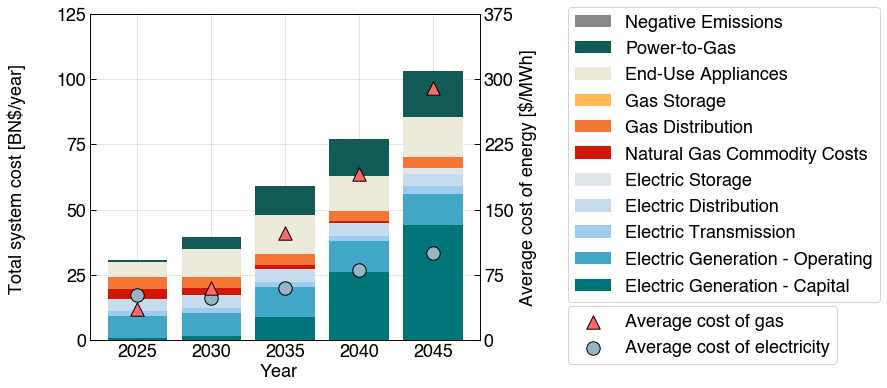

In [529]:
colors_Costs = ["#00767B","#42A7C6",
    "#9DCCEF","#C6DBED","#DEE6E7",
    "#D11807","#F57634","#FFB954",
    "#ECEADA","#125A56","#888888"]
labels_Costs = ["Electric Generation - Capital","Electric Generation - Operating",
    "Electric Transmission","Electric Distribution","Electric Storage",
    "Natural Gas Commodity Costs","Gas Distribution","Gas Storage",
    "End-Use Appliances","Power-to-Gas","Negative Emissions"]

fig, axes = plt.subplots(1, 1, figsize = (7,6), sharex = False, sharey = False)

folder = folder1
data = np.transpose(pd.read_csv(f"%s/EMISSIONS_COSTS.csv" % folder).to_numpy())
stack = np.zeros((T_inv))
count = 8
for k in range(len(labels_Costs)):
    if k == 0:
        axes.bar(Years, data[3,:]/10**9, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center")
        stack = stack + data[3,:]/10**9
    if k == 1:
        axes.bar(Years, (data[4,:] + data[5,:])/10**9, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center")
        stack = stack + (data[4,:] + data[5,:])/10**9
    if k == 2:
        axes.bar(Years, (data[19,:] +data[24,:])/10**9, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center")
        stack = stack + (data[19,:] +data[24,:])/10**9  
    if k == 3:
        axes.bar(Years, data[7,:]/10**9, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center")
        stack = stack + data[7,:]/10**9  
    if k == 4:
        axes.bar(Years, data[6,:]/10**9, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center")
        stack = stack + data[6,:]/10**9  
    if k > 4:
        axes.bar(Years, data[count,:]/10**9, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center")
        stack = stack + data[count,:]/10**9
        print(count,labels_Costs[k], data[count,:]/10**9)
        count = count+1
        
axes2 = axes.twinx()

# Scatter for average gas and electricity costs
axes2.scatter(Years,data[0,:], label = "Average cost of electricity", color = "#96B6C5", edgecolors= 'k', s = 180)
axes2.scatter(Years,data[1,:], label = "Average cost of gas", color = "#FF6868", edgecolors= 'k' , s = 180,marker="^")
axes.tick_params(direction='in', length=6, width=1, colors='k')
axes2.tick_params(direction='in', length=6, width=1, colors='k')
axes.axhline(linewidth=1, color='k')
axes2.axhline(linewidth=1, color='k')

handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.2, 1.05), loc='upper left', prop={'size': 18})
handles, labels = axes2.get_legend_handles_labels()
axes2.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.2, -0.1), loc='lower left', prop={'size': 18})
axes.set_ylim([0,125])
axes2.set_ylim([0,375])
fig.text(-0.02, 0.5, 'Total system cost [BN$/year]', ha='center', va='center', rotation='vertical')
axes.set_axisbelow(True)
axes.grid(color='grey', linestyle='-', linewidth=1,alpha = 0.2)
axes.set_yticks(np.arange(0,150, step=25))
axes2.set_yticks(np.arange(0,400, step=75))

axes2.set_ylabel("Average cost of energy [$/MWh]")
fig.text(0.5, 0.04, 'Year', ha='center')
# fig.savefig(f"Plots/{case_study}/Total_Costs_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()

Power Generation Emissions [5.18558632e+01 4.65189873e+01 4.29888291e+01 2.73259747e+01
 3.54258618e-05]
Other Gas Demand Emissions [4.35078015e+01 3.43262971e+01 2.17643408e+01 1.04318002e+01
 7.45058060e-15]


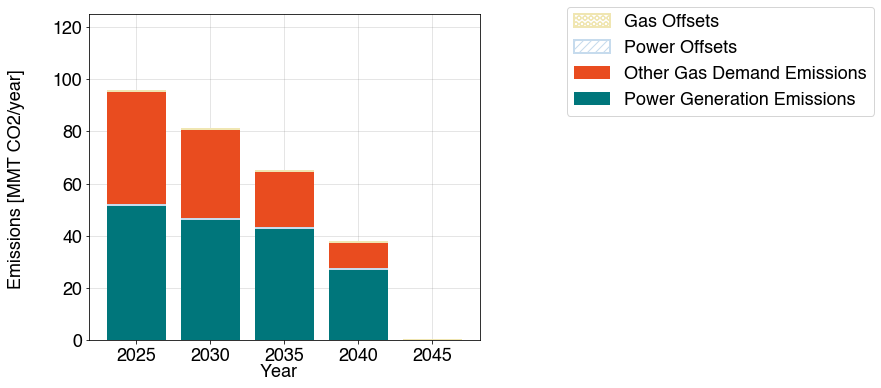

In [368]:
colors_Costs = ["#00767B","#E94C1F"]
labels_Costs = ["Power Generation Emissions", "Other Gas Demand Emissions"]

fig, axes = plt.subplots(1, 1, figsize = (7,6), sharex = False, sharey = False)

for i in range(len(appliance_cases)):
    folder = folder1
    data = np.transpose(pd.read_csv(f"%s/EMISSIONS_COSTS.csv" % folder).to_numpy())
    stack = np.zeros((T_inv))
    resources_bg = stack
    count = 20
    for k in range(len(labels_Costs)):
        axes.bar(Years, data[count,:]/10**6, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center")
        stack = stack + data[count,:]/10**6       
        print(labels_Costs[k],data[count,:]/10**6)
        count = count+1
        
    stack = np.zeros((T_inv))
    axes.bar(Years, data[count,:]/10**6, label = "Power Offsets", color = "none", alpha = 1, hatch='///', edgecolor = '#C6DBED',linewidth = 2, bottom = data[20,:]/10**6-data[22,:]/10**6, width = 4, align = "center")
    axes.bar(Years, data[count+1,:]/10**6, label = "Gas Offsets", color = "none", alpha = 1, hatch='OO', linewidth = 2,edgecolor = '#F0E6B2', bottom = data[20,:]/10**6+data[21,:]/10**6-data[23,:]/10**6, width = 4, align = "center")

axes.set_axisbelow(True)
axes.grid(color='grey', linestyle='-', linewidth=1,alpha = 0.2)
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.2, 1.05), loc='upper left', prop={'size': 18})
axes.set_ylim([0,125])
fig.text(-0.02, 0.5, 'Emissions [MMT CO2/year]', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Year', ha='center')
# fig.savefig(f"Plots/{case_study}/Emissions_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()

## Locational Capacity Cumulative Build 

<ipython-input-536-5f92f6a15cec>:37: RuntimeWarning: invalid value encountered in divide
  cum_data = np.cumsum(data_plot[i,:]) / np.cumsum(data_plot[i,:])[-1]


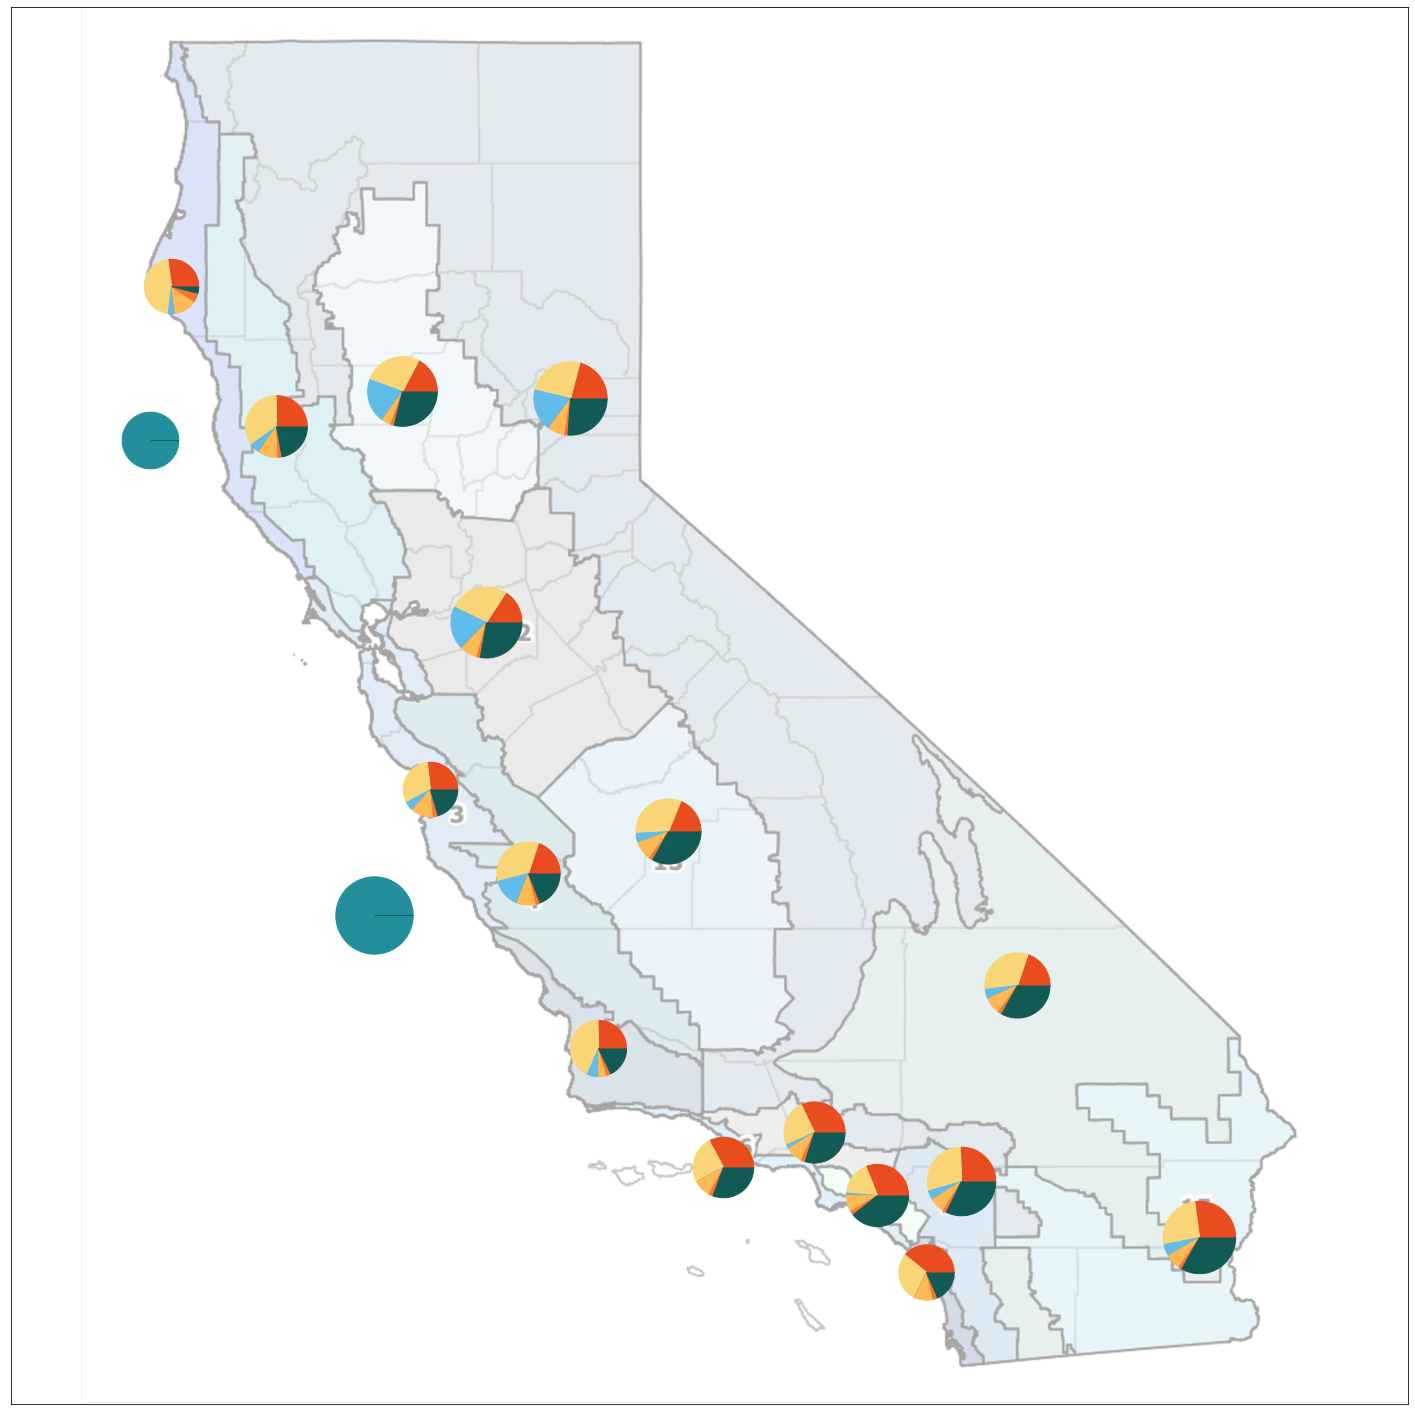

In [536]:
result_yr = 5

fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)
xx = 0

# img = plt.imread("Plots/climatezone.png")
# axes.imshow(img, extent=[0.5, 10.5, 0, 10])

nodal_locs = np.random.rand(np.max(locational_resources),2)
nodal_locs[:,0] = np.array([1.15,1.9, 3.0 ,  3.7,  4.20, 5.1,  6.55,  6.2, 5.75, 6.8, 2.80, 3.4, 4.7, 7.2, 8.5, 4.0, 2.9 ,4.7,8.5,9,1.0, 2.6])
nodal_locs[:,1] = np.array([8   ,  7, 4.4 ,  3.8,  2.55, 1.7,  0.95,  1.5, 1.95, 1.6, 7.25, 5.6, 4.1, 3.0, 1.2, 7.2, 9.85,7.6,3.8,1.2,6.9, 3.5])

for ii in range(len(appliance_cases)):
    data_plot = np.zeros((np.max(locational_resources),len(unique_resources)))
    data = pd.read_csv(f"%s/CAPACITY_BUILT.csv" % folder).to_numpy()
    data = data[0:-1,:]
    data_retired = pd.read_csv(f"%s/CAPACITY_RETIRED.csv" % folder).to_numpy()
    data_retired = data_retired[0:-1,:]
    stack = np.zeros((T_inv))
    stack_minus = stack.copy()
    for kk in range(np.max(locational_resources)):
        resources = np.zeros((len(unique_resources),T_inv))
        resources_minus = np.zeros((len(unique_resources),T_inv))
        for k in range(len(unique_resources)):
            for j in range(T_inv):
                for jj in range(j+1):
                    resources_minus[k,j] = resources_minus[k,j]+np.sum(data_retired[(resource_list == unique_resources[k]) & (locational_resources == kk+1),jj],0)
                    resources[k,j] = resources[k,j]+np.sum(data[(resource_list == unique_resources[k]) & (locational_resources == kk+1),jj],0)

            data_plot[kk,k] = resources[k,result_yr-1]
            
    sizes = 550*np.random.rand(np.max(locational_resources)) + 250
    sizes = np.sum(data_plot,1)*0.6
    for i in range(len(data_plot[:,0])):
        r = np.zeros((len(data_plot[0,:])+1))
        loc = nodal_locs[i,:]
        cum_data = np.cumsum(data_plot[i,:]) / np.cumsum(data_plot[i,:])[-1]
        cum_data[np.isnan(cum_data)] = 0
        for j in range(len(data_plot[0,:])):
            r[j+1] = cum_data[j]
            x = np.cos(2 * np.pi * np.linspace(r[j], r[j+1]))
            y = np.sin(2 * np.pi * np.linspace(r[j], r[j+1]))
            xy = np.row_stack([[0, 0], np.column_stack([x, y])])
            s1 = np.abs(xy).max()
            axes.scatter(loc[0], loc[1], marker=xy, s=s1**2 * sizes[i], facecolor = colors[j])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xlim([0,10])
    axes.set_ylim([0,10])
    # axes.patch.set_facecolor('white')
    axes.patch.set_alpha(0.7)
fig.savefig(f"Plots/{case_study}/Locational_CAP_{result_yr}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.tight_layout()


## Locational Generation Mix 

<ipython-input-71-c396e1cbdaa3>:33: RuntimeWarning: invalid value encountered in divide
  cum_data = np.cumsum(data_plot[i,:]) / np.cumsum(data_plot[i,:])[-1]


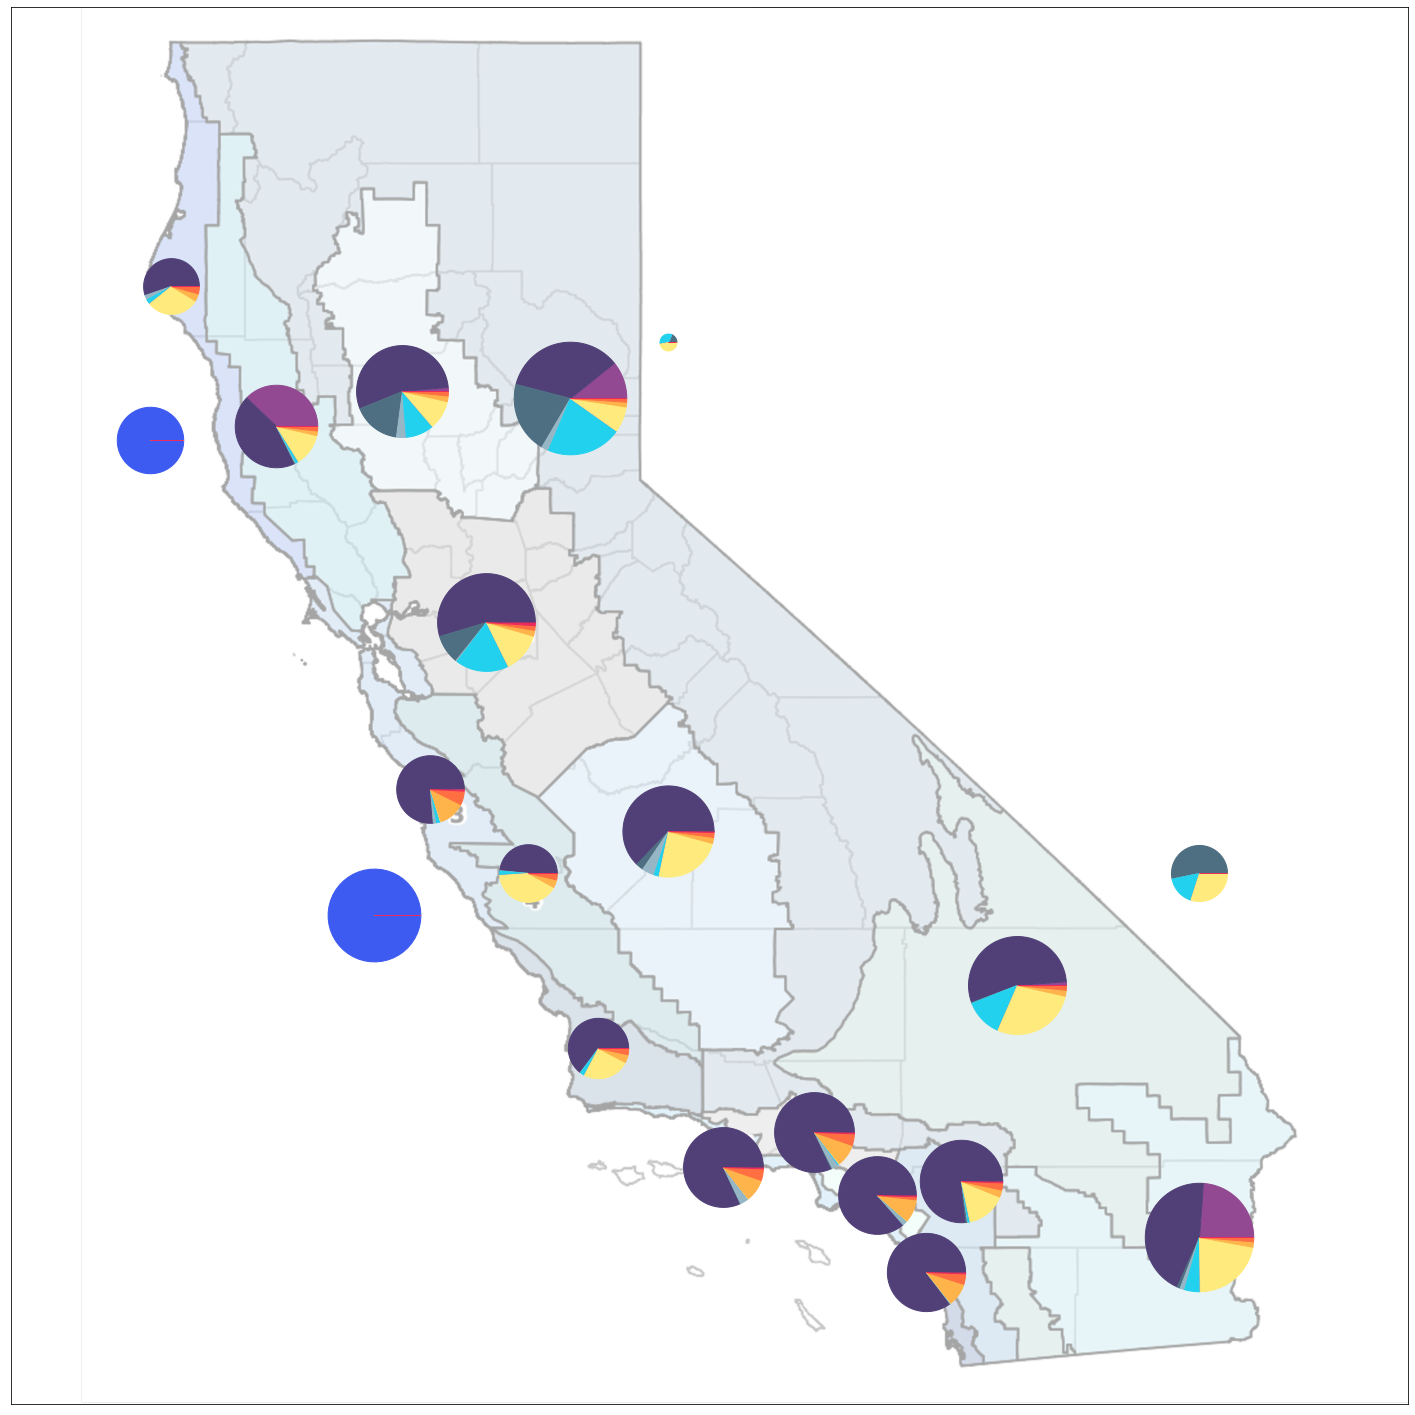

In [71]:
result_yr = 5

fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)
xx = 0

img = plt.imread("Plots/climatezone.png")
axes.imshow(img, extent=[0.5, 10.5, 0, 10])

nodal_locs = np.random.rand(np.max(locational_resources_GEN),2)
nodal_locs[:,0] = np.array([1.15,1.9, 3.0 ,  3.7,  4.20, 5.1,  6.55,  6.2, 5.75, 6.8, 2.80, 3.4, 4.7, 7.2, 8.5, 4.0, 2.9 ,4.7,8.5,9,1.0, 2.6])
nodal_locs[:,1] = np.array([8   ,  7, 4.4 ,  3.8,  2.55, 1.7,  0.95,  1.5, 1.95, 1.6, 7.25, 5.6, 4.1, 3.0, 1.2, 7.2, 9.85,7.6,3.8,1.2,6.9, 3.5])

for ii in range(len(appliance_cases)):
    data_plot = np.zeros((np.max(locational_resources_GEN),len(unique_resources_GEN)))
    data = pd.read_csv(f"%s/GENERATION.csv" % folder).to_numpy()
    data = data[0:-1,:]
    data = data[0:237]
    stack = np.zeros((T_inv))
    stack_minus = stack.copy()
    for kk in range(np.max(locational_resources_GEN)):
        resources = np.zeros((len(unique_resources_GEN),T_inv))
        for k in range(len(unique_resources_GEN)):
            for j in range(T_inv):
                    resources[k,j] = resources[k,j]+np.sum(data[(resource_list_GEN == unique_resources_GEN[k]) & (locational_resources_GEN == kk+1),jj],0)

            data_plot[kk,k] = resources[k,result_yr-1]
            
    sizes = np.random.rand(np.max(locational_resources_GEN))
    sizes = np.sum(data_plot,1)*0.0002
    for i in range(len(data_plot[:,0])):
        r = np.zeros((len(data_plot[0,:])+1))
        loc = nodal_locs[i,:]
        cum_data = np.cumsum(data_plot[i,:]) / np.cumsum(data_plot[i,:])[-1]
        cum_data[np.isnan(cum_data)] = 0
        for j in range(len(data_plot[0,:])):
            r[j+1] = cum_data[j]
            x = np.cos(2 * np.pi * np.linspace(r[j], r[j+1]))
            y = np.sin(2 * np.pi * np.linspace(r[j], r[j+1]))
            xy = np.row_stack([[0, 0], np.column_stack([x, y])])
            s1 = np.abs(xy).max()
            axes.scatter(loc[0], loc[1], marker=xy, s=s1**2 * sizes[i], facecolor = colors[j])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xlim([0,10])
    axes.set_ylim([0,10])
    # axes.patch.set_facecolor('white')
    axes.patch.set_alpha(0.7)
# fig.savefig(f"Plots/{case_study}/Locational_GEN_{result_yr}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.tight_layout()


## Locational Total Existing Appliance

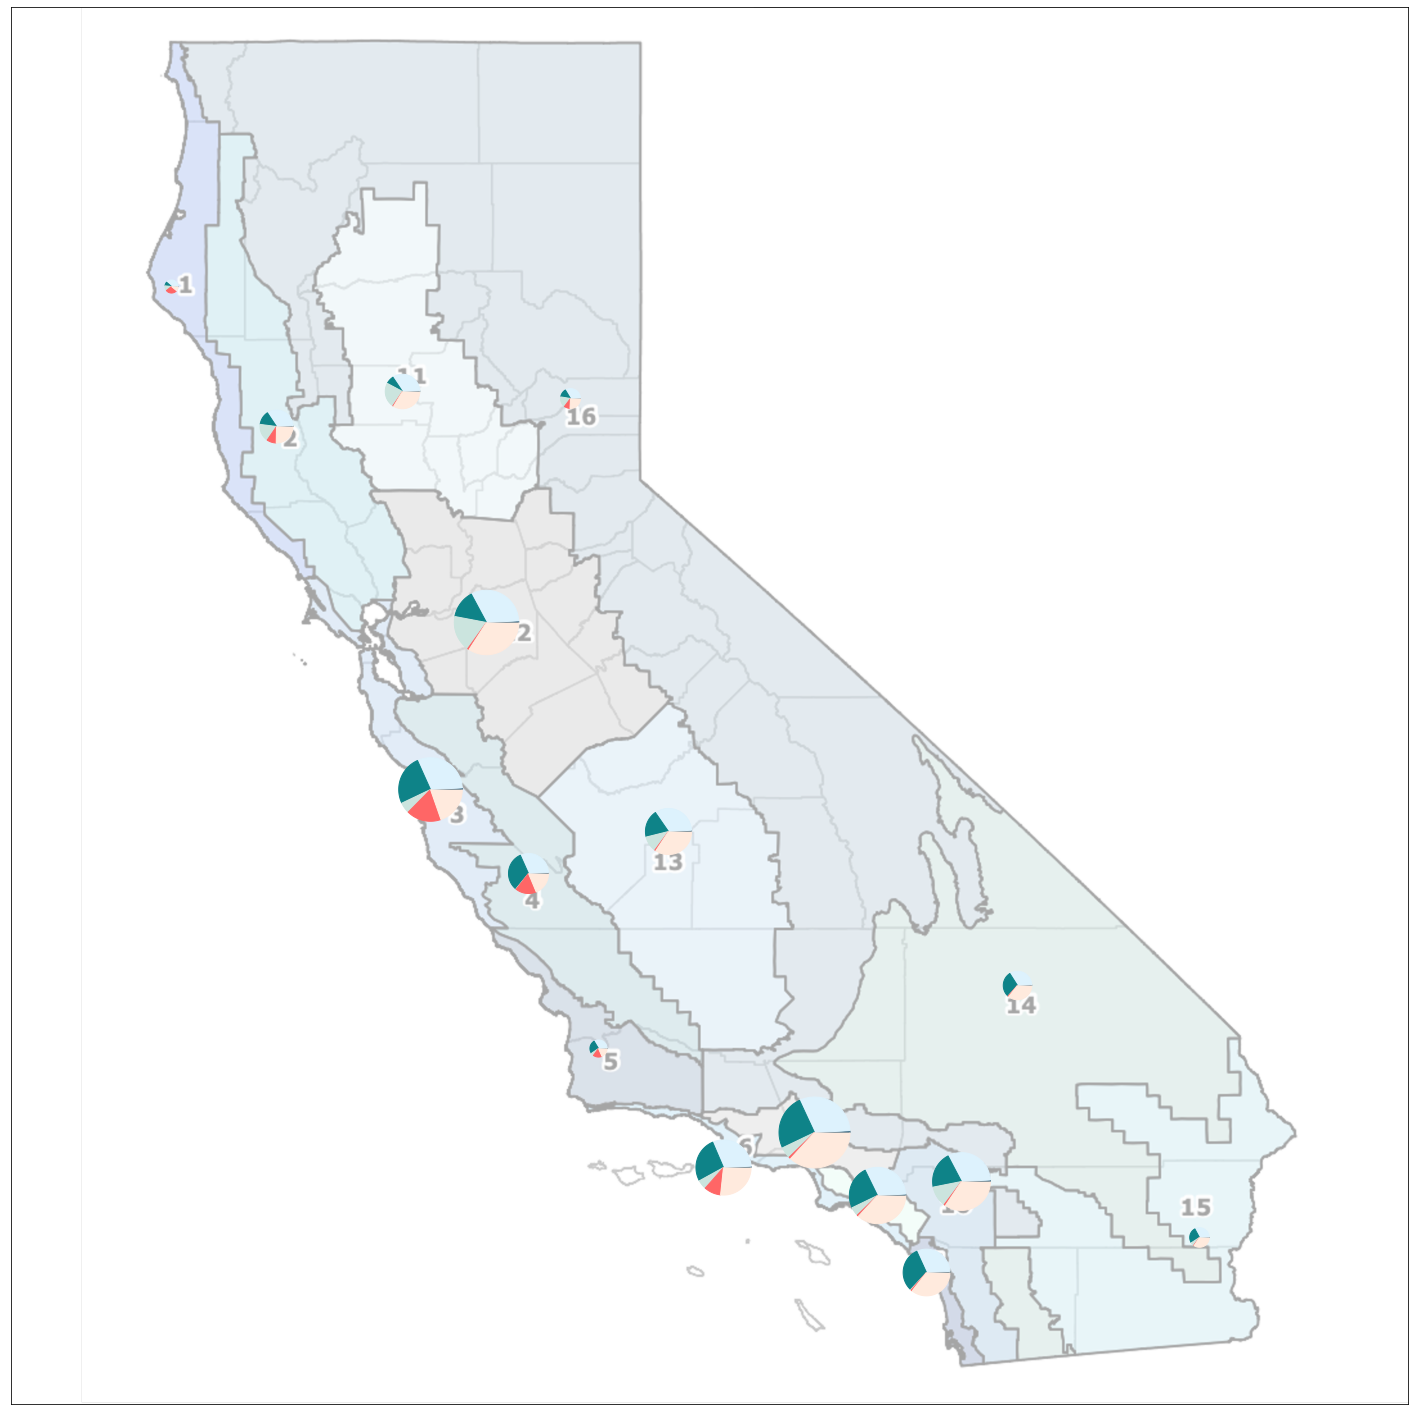

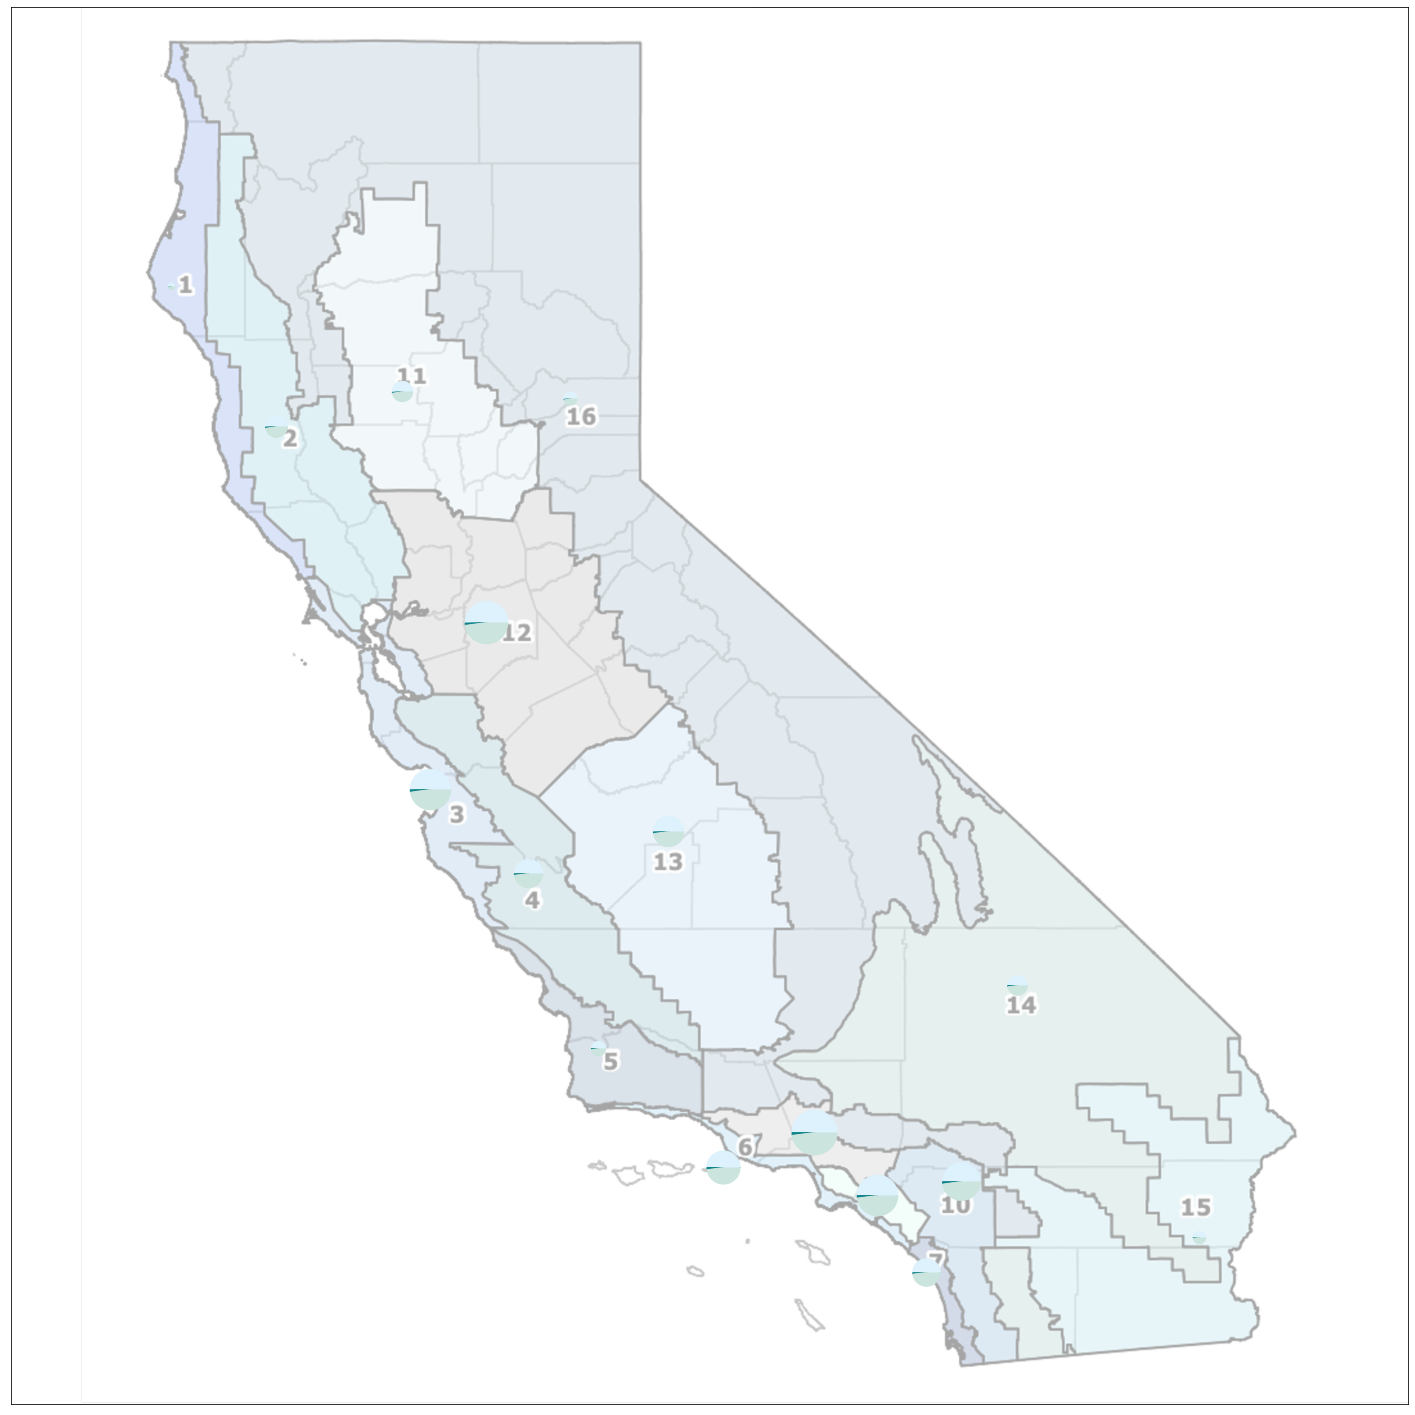

In [72]:
################################################################################################
## Locational Capacity Appliance Total RESIDENTIAL
################################################################################################
result_yr = 5 # 1-5

fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)
xx = 0

img = plt.imread("Plots/climatezone.png")
axes.imshow(img, extent=[0.5, 10.5, 0, 10])

nodal_locs = np.random.rand(np.max(locational_resources),2)
nodal_locs[:,0] = np.array([1.15,1.9, 3.0 ,  3.7,  4.20, 5.1,  6.55,  6.2, 5.75, 6.8, 2.80, 3.4, 4.7, 7.2, 8.5, 4.0, 0,0,8,0,1.0, 2.6])
nodal_locs[:,1] = np.array([8   ,  7, 4.4 ,  3.8,  2.55, 1.7,  0.95,  1.5, 1.95, 1.6, 7.25, 5.6, 4.1, 3.0, 1.2, 7.2, 0,0,4,0,6.9, 3.5])

for ii in range(len(appliance_cases)):
    data_plot = np.zeros((np.max(locational_resources_appliances),len(unique_appliancetypes_RES)))
    data = pd.read_csv(f"%s/APPLIANCE_DECISIONS.csv" % folder).to_numpy()

    newbuild = np.zeros((len(data[:,0]),T_inv))
    premature = np.zeros((len(data[:,0]),T_inv))
    totalpop = np.zeros((len(data[:,0]),T_inv))
    for k in range(T_inv):
        newbuild[:,k] = data[:,k*3]
        premature[:,k] = data[:,k*3+1]
        totalpop[:,k] = data[:,k*3+2]
    newtotalpop = np.zeros((len(data[:,0]),T_inv+1))
    newtotalpop[:,0] = initial_pop
    newtotalpop[:,1:6] = totalpop
    

    data = newtotalpop
    stack = np.zeros((T_inv+1))
    stack_minus = stack.copy()
    for kk in range(np.max(locational_resources_appliances)):
        resources = np.zeros((len(unique_appliancetypes_RES),T_inv+1))
        # resources_minus = np.zeros((len(unique_appliancetypes_RES),T_inv))
        for k in range(len(unique_appliancetypes_RES)):
            for j in range(T_inv+1):
                for jj in range(j+1):
                    # resources_minus[k,j] = resources_minus[k,j]+np.sum(data_retired[(resource_list == unique_resources[k]) & (locational_resources == kk+1),jj],0)
                    resources[k,j] = np.sum(data[(appliances_list == unique_appliancetypes_RES[k]) & (locational_resources_appliances == kk+1),jj],0)

            data_plot[kk,k] = resources[k,result_yr]
            
    sizes = np.random.rand(np.max(locational_resources_appliances)) 
    sizes = np.sum(data_plot,1)*1.0
    for i in range(len(data_plot[:,0])):
        r = np.zeros((len(data_plot[0,:])+1))
        loc = nodal_locs[i,:]
        cum_data = np.cumsum(data_plot[i,:])/ np.cumsum(data_plot[i,:])[-1]
        cum_data[np.isnan(cum_data)] = 0
        for j in range(len(data_plot[0,:])):
            r[j+1] = cum_data[j]
            x = np.cos(2 * np.pi * np.linspace(r[j], r[j+1]))
            y = np.sin(2 * np.pi * np.linspace(r[j], r[j+1]))
            xy = np.row_stack([[0, 0], np.column_stack([x, y])])
            s1 = np.abs(xy).max()
            axes.scatter(loc[0], loc[1], marker=xy, s=s1**2 * sizes[i], facecolor = colors_ResApps[j])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xlim([0,10])
    axes.set_ylim([0,10])
    # axes.patch.set_facecolor('white')
    axes.patch.set_alpha(0.7)
# fig.savefig(f"Plots/{case_study}/Locational_Plot_AppliancesTotal_{result_yr}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.tight_layout()

################################################################################################
## Locational Capacity Appliance Total COMMERCIAL
################################################################################################


fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)
xx = 0

img = plt.imread("Plots/climatezone.png")
axes.imshow(img, extent=[0.5, 10.5, 0, 10])

nodal_locs = np.random.rand(np.max(locational_resources),2)
nodal_locs[:,0] = np.array([1.15,1.9, 3.0 ,  3.7,  4.20, 5.1,  6.55,  6.2, 5.75, 6.8, 2.80, 3.4, 4.7, 7.2, 8.5, 4.0, 0,0,8,0,1.0, 2.6])
nodal_locs[:,1] = np.array([8   ,  7, 4.4 ,  3.8,  2.55, 1.7,  0.95,  1.5, 1.95, 1.6, 7.25, 5.6, 4.1, 3.0, 1.2, 7.2, 0,0,4,0,6.9, 3.5])

for ii in range(len(appliance_cases)):
    data_plot = np.zeros((np.max(locational_resources_appliances),len(unique_appliancetypes_COMM)))
    data = pd.read_csv(f"%s/APPLIANCE_DECISIONS.csv" % folder).to_numpy()

    newbuild = np.zeros((len(data[:,0]),T_inv))
    premature = np.zeros((len(data[:,0]),T_inv))
    totalpop = np.zeros((len(data[:,0]),T_inv))
    for k in range(T_inv):
        newbuild[:,k] = data[:,k*3]
        premature[:,k] = data[:,k*3+1]
        totalpop[:,k] = data[:,k*3+2]
    newtotalpop = np.zeros((len(data[:,0]),T_inv+1))
    newtotalpop[:,0] = initial_pop
    newtotalpop[:,1:6] = totalpop
    

    data = newtotalpop
    stack = np.zeros((T_inv+1))
    stack_minus = stack.copy()
    for kk in range(np.max(locational_resources_appliances)):
        resources = np.zeros((len(unique_appliancetypes_COMM),T_inv+1))
        # resources_minus = np.zeros((len(unique_appliancetypes_RES),T_inv))
        for k in range(len(unique_appliancetypes_COMM)):
            for j in range(T_inv+1):
                for jj in range(j+1):
                    # resources_minus[k,j] = resources_minus[k,j]+np.sum(data_retired[(resource_list == unique_resources[k]) & (locational_resources == kk+1),jj],0)
                    resources[k,j] = np.sum(data[(appliances_list == unique_appliancetypes_COMM[k]) & (locational_resources_appliances == kk+1),jj],0)

            data_plot[kk,k] = resources[k,result_yr]
            
    sizes = np.random.rand(np.max(locational_resources_appliances)) 
    sizes = np.sum(data_plot,1)*40
    for i in range(len(data_plot[:,0])):
        r = np.zeros((len(data_plot[0,:])+1))
        loc = nodal_locs[i,:]
        cum_data = np.cumsum(data_plot[i,:])/ np.cumsum(data_plot[i,:])[-1]
        cum_data[np.isnan(cum_data)] = 0
        for j in range(len(data_plot[0,:])):
            r[j+1] = cum_data[j]
            x = np.cos(2 * np.pi * np.linspace(r[j], r[j+1]))
            y = np.sin(2 * np.pi * np.linspace(r[j], r[j+1]))
            xy = np.row_stack([[0, 0], np.column_stack([x, y])])
            s1 = np.abs(xy).max()
            axes.scatter(loc[0], loc[1], marker=xy, s=s1**2 * sizes[i], facecolor = colors_CommApps[j])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xlim([0,10])
    axes.set_ylim([0,10])
    # axes.patch.set_facecolor('white')
    axes.patch.set_alpha(0.7)
# fig.savefig(f"Plots/{case_study}/Locational_Plot_AppliancesTotal_{result_yr}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.tight_layout()



## Locational Total Appliance Consumption

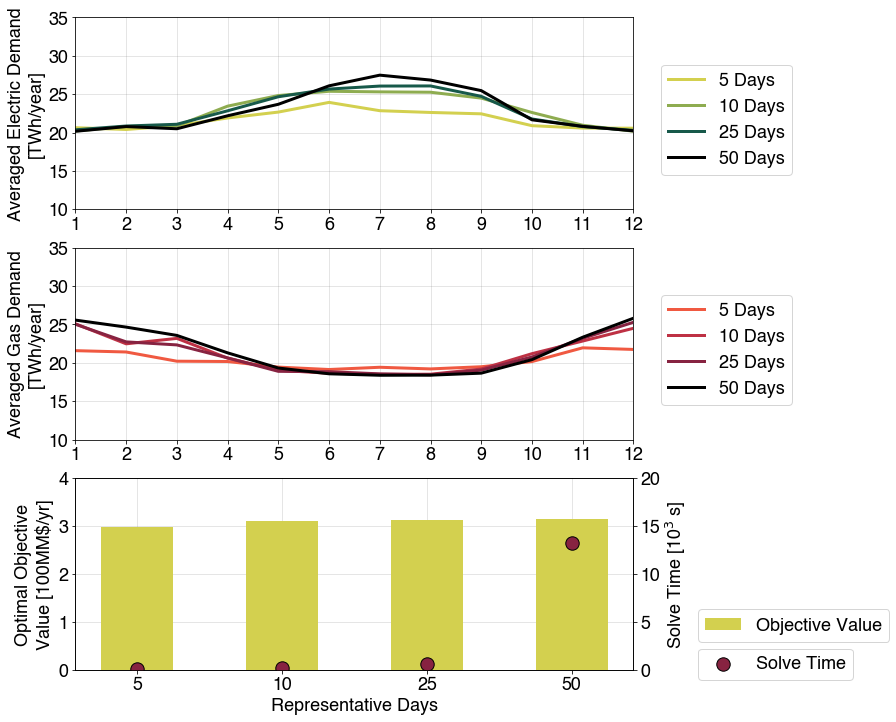

In [100]:
fig, axes = plt.subplots(3, 1, figsize = (10,12), sharex = False, sharey = False)

colors1 = ["#D3D04F","#8EAC50","#17594A","black"]
colors2 = ["#F05941","#BE3144","#872341","black"]
casename = ["5 Days","10 Days", "25 Days", "50 Days", "365 Days"]
folderX = ["Core/Output/Validate/R5","Core/Output/Validate/R10", "Core/Output/Validate/R25", "Core/Output/Validate/R50"]
data_gas = np.zeros((4,12))
data_elec = np.zeros((4,12))
for i in range(len(folderX)):
    data = pd.read_csv(f"%s/HOURLY_LOAD.csv" % folderX[i]).to_numpy()
    demand_array = data[0,:]
    reshaped_array = np.reshape(demand_array, (12, -1))
    monthly_demand = np.sum(reshaped_array, axis=1)
    data_elec[i,:] = monthly_demand/1e6

    demand_array = data[1,:]
    reshaped_array = np.reshape(demand_array, (12, -1))
    monthly_demand = np.sum(reshaped_array, axis=1)
    data_gas[i,:] = monthly_demand/1e6

for j in [0,1]:
    for m in range(4):
        if j == 0:
            axes[j].plot(np.linspace(1,12,12),np.transpose(data_elec[m,:]),linewidth = 3,label = casename[m],color = colors1[m])
            axes[j].set_ylabel("Averaged Electric Demand\n[TWh/year]")
        else:
            axes[j].plot(np.linspace(1,12,12),np.transpose(data_gas[m,:]),linewidth = 3,label = casename[m],color = colors2[m])
            axes[j].set_ylabel("Averaged Gas Demand\n[TWh/year]")
    axes[j].set_axisbelow(True)
    axes[j].grid(color='grey', linestyle='-', linewidth=1,alpha = 0.2)
    # axes[j].set_xlabel("Month")
    axes[j].set_xlim(1,12)
    axes[j].set_ylim(10,35)
    axes[j].set_xticks(np.arange(1, 13, step=1))
    axes[j].legend(loc='upper right', bbox_to_anchor=(1.3, 0.8))

axes[2].bar(["5","10","25","50"],[2.98599504,3.10384554,3.12212954,3.14048470], label = "Objective Value", width = 0.5, color = "#D3D04F")
axes[2].set_ylabel("Optimal Objective\nValue [100MM$/yr]")
axes[2].set_ylim(0,4)
axes2 = axes[2].twinx()
axes2.scatter(["5","10","25","50"],[0.126,0.143,0.562,13.188], label = "Solve Time", color = "#872341", edgecolors= 'k', s = 180)
axes2.set_ylabel("Solve Time [10$^3$ s]")
handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 0.1), loc='lower left', prop={'size': 18})
handles, labels = axes2.get_legend_handles_labels()
axes2.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, -0.1), loc='lower left', prop={'size': 18})
axes2.set_ylim(0,20)
axes[2].set_xlabel("Representative Days")
axes[2].set_axisbelow(True)
axes[2].grid(color='grey', linestyle='-', linewidth=1,alpha = 0.2)

fig.savefig(f"Plots/Validation/Validation - Rep Days.png", transparent=True,bbox_inches = "tight", dpi = 300)


In [514]:
data = pd.read_csv("Data/ApplianceProfiles_ELECNetworkCold.csv")
timestamp = pd.read_csv("Plots/2018_time.csv")
month = timestamp["Month"]
hour = timestamp["Hour"]
index_profile = ["x18","x50","x82"] # x50 SH CZ2, x18 WH CZ2
hourly_av = np.zeros((len(index_profile),12,24))
for i in range(len(index_profile)):
    app_profile = data[index_profile[i]]
    for j in range(8760):
        hourly_av[i,month[j]-1,hour[j]-1] += app_profile[j]

days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
for m in range(12):
    hourly_av[:,m,:] = hourly_av[:,m,:]/days_in_month[m]*1000

colors_ResApps = ["#E94C1F","#ECEADA","#A01813","#FDDBC7","#125A56","#00767B","#DEE6E7","#DEE6E7"]


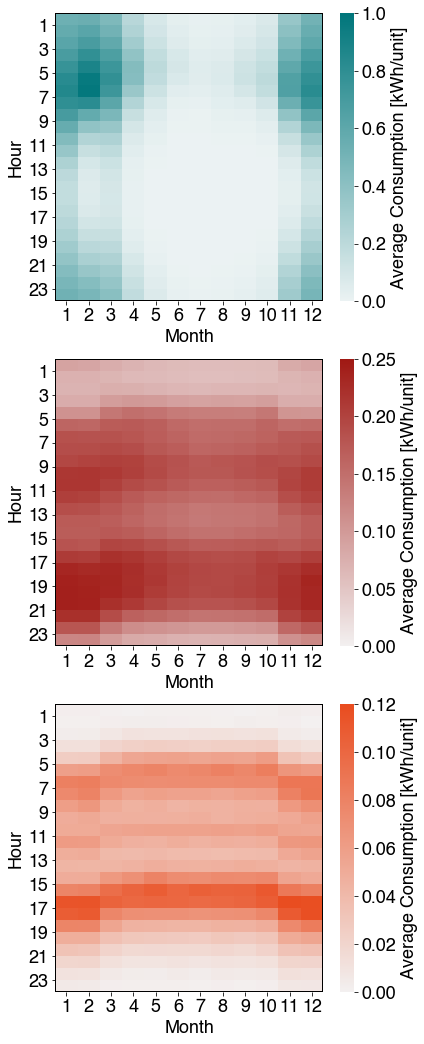

In [517]:
import seaborn as sns
fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize = (6,18))
ax1.get_shared_y_axes().join(ax2,ax3)

x_axis_labels = [1,2,3,4,5,6,7,8,9,10,11,12]
l = np.arange(1, 24+1, 2)

cmap_sh = sns.color_palette("light:#00767B", as_cmap=True)
p2 = sns.heatmap(np.transpose(hourly_av[1,:,:]),cmap=cmap_sh,xticklabels=x_axis_labels, vmin=0, vmax=1,
                 ax=ax1,cbar_kws={'label': 'Average Consumption [kWh/unit]'})
p2.set(xlabel='Month', ylabel='Hour',yticks=l, yticklabels=l)
p2.set_yticklabels(rotation=0,labels=l)

cmap_wh = sns.color_palette("light:#A01813", as_cmap=True)
p1 = sns.heatmap(np.transpose(hourly_av[0,:,:]),cmap=cmap_wh,xticklabels=x_axis_labels, vmin=0, vmax=0.25,
                 ax=ax2,cbar_kws={'label': 'Average Consumption [kWh/unit]'})
p1.set(xlabel='Month', ylabel='Hour',yticks=l, yticklabels=l)
p1.set_yticklabels(rotation=0,labels=l)

cmap_ck = sns.color_palette("light:#E94C1F", as_cmap=True)
p3 = sns.heatmap(np.transpose(hourly_av[2,:,:]),cmap=cmap_ck,xticklabels=x_axis_labels, vmin=0, vmax=0.12,
                 ax=ax3,cbar_kws={'label': 'Average Consumption [kWh/unit]'})
p3.set(xlabel='Month', ylabel='Hour',yticks=l, yticklabels=l)
p3.set_yticklabels(rotation=0,labels=l)

p1.axhline(y = 0, color='k',linewidth = 1) 
p1.axhline(y = 23.9, color = 'k', linewidth = 1) 
p1.axvline(x = 0, color = 'k', linewidth = 1) 
p1.axvline(x = 11.95,  color = 'k', linewidth = 1) 
p2.axhline(y = 0, color='k',linewidth = 1) 
p2.axhline(y = 23.9, color = 'k', linewidth = 1) 
p2.axvline(x = 0, color = 'k', linewidth = 1) 
p2.axvline(x = 11.95,  color = 'k', linewidth = 1) 
p3.axhline(y = 0, color='k',linewidth = 1) 
p3.axhline(y = 23.9, color = 'k', linewidth = 1) 
p3.axvline(x = 0, color = 'k', linewidth = 1) 
p3.axvline(x = 11.95,  color = 'k', linewidth = 1) 

fig.savefig(f"Plots/Validation/Data - Hourly Average Appliances.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.show()

In [448]:
unique_resources = np.array(['Coal', 'Natural Gas', 'Biomass', 'Geothermal', 'Nuclear',
 'Hydro', 'Solar PV', 'Wind', 'Offshore Wind',
 'Short-Duration Storage', 'Long-Duration Storage','Power-to-Gas'])
unique_resources_GEN = unique_resources[:-3]
colors = np.array(['#000000','#888888', '#00767B', '#E94C1F', '#A01813',
    '#C6DBED', '#F9D576','#60BCE9', '#238F9D', 
    '#FFB954', '#F57634','#125A56'])

'Solar PV'

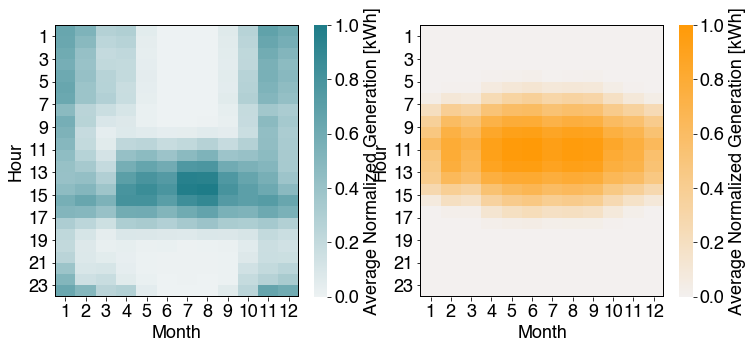

In [509]:
dataX = pd.read_csv(f"%s/HOURLY_GENERATION.csv" % folder).to_numpy()
yr = 4

data = dataX[0:-1,int(yr*8760):int((yr+1)*8760)]/1000       # data follows resource_list_hourly
resources = np.zeros((8760,2))
for k in [9]:
    resources[:,0] += np.maximum(data[107],0)
for k in [6]:
    resources[:,1] += np.maximum(data[20],0)
    # print(unique_resources_GEN[k])

hourly_vre = np.zeros((2,12,24))
for j in range(8760):
    hourly_vre[0,month[j]-1,hour[j]-1] += resources[j,0]
    hourly_vre[1,month[j]-1,hour[j]-1] += resources[j,1]

days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
for m in range(12):
    hourly_vre[:,m,:] = hourly_vre[:,m,:]/days_in_month[m]*1000
hourly_vre[0,:,:] = hourly_vre[0,:,:]/np.max(hourly_vre[0,:,:])
hourly_vre[1,:,:] = hourly_vre[1,:,:]/np.max(hourly_vre[1,:,:])

fig,(ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
x_axis_labels = [1,2,3,4,5,6,7,8,9,10,11,12]
l = np.arange(1, 24+1, 2)

cmap_wh = sns.color_palette("light:#1e7c88", as_cmap=True)
p1 = sns.heatmap(np.transpose(hourly_vre[0,:,:]),cmap=cmap_wh,xticklabels=x_axis_labels,
                 ax=ax1,cbar_kws={'label': 'Average Normalized Generation [kWh]'})
p1.set(xlabel='Month', ylabel='Hour',yticks=l, yticklabels=l)
p1.set_yticklabels(rotation=0,labels=l)

cmap_wh = sns.color_palette("light:#ff9a07", as_cmap=True)
p2 = sns.heatmap(np.transpose(hourly_vre[1,:,:]),cmap=cmap_wh,xticklabels=x_axis_labels,
                 ax=ax2,cbar_kws={'label': 'Average Normalized Generation [kWh]'})
p2.set(xlabel='Month', ylabel='Hour',yticks=l, yticklabels=l)
p2.set_yticklabels(rotation=0,labels=l)

p1.axhline(y = 0, color='k',linewidth = 1) 
p1.axhline(y = 23.9, color = 'k', linewidth = 1) 
p1.axvline(x = 0, color = 'k', linewidth = 1) 
p1.axvline(x = 11.95,  color = 'k', linewidth = 1) 
p2.axhline(y = 0, color='k',linewidth = 1) 
p2.axhline(y = 23.9, color = 'k', linewidth = 1) 
p2.axvline(x = 0, color = 'k', linewidth = 1) 
p2.axvline(x = 11.95,  color = 'k', linewidth = 1) 

# fig.savefig(f"Plots/Validation/Data - Hourly Average Renewables.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.show()

## Gas and Electricity Flow Between Regions

In [ ]:
def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [ ]:
################################################################################################
## Flow gas and electricity
################################################################################################
from numpy import linalg as LA
fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)

img = plt.imread("Plots/climatezone.png")
axes.imshow(img, extent=[0.5, 10.5, 0, 10])

nodal_locs = np.random.rand(np.max(locational_resources),2)
nodal_locs[:,0] = np.array([1.15,1.9, 3.0 ,  3.7,  4.20, 5.1,  6.55,  6.2, 5.75, 6.8, 2.80, 3.4, 4.7, 7.2, 8.5, 4.0, 2.9 ,4.7,8.5,9,1.0, 2.6])
nodal_locs[:,1] = np.array([8   ,  7, 4.4 ,  3.8,  2.55, 1.7,  0.95,  1.5, 1.95, 1.6, 7.25, 5.6, 4.1, 3.0, 1.2, 7.2, 9.85,7.6,3.8,1.2,6.9, 3.5])

# data_gas (row = edge, col = days for yrs 1-5)
# data_elec (row = edge, col = hours in day, days for yrs 1-5)
data_gas = pd.read_csv(f"%s/DAILY_GAS_TRANSMISSION.csv" % folder).to_numpy()
data_elec = pd.read_csv(f"%s/HOURLY_ELECTRIC_TRANSMISSION.csv" % folder).to_numpy()
elec_network = pd.read_csv("Data/ElecTransmissionNetwork.csv")
nodein_elec = elec_network["Node In"]
nodeout_elec = elec_network["Node Out"]
gas_network = pd.read_csv("Data/GasTransmissionNetwork.csv")
nodein_gas = gas_network["Node In"]
nodeout_gas = gas_network["Node Out"]

yr = 4
cd = 2
d = 1 # no changing this!
hr = 17
max_gas = np.amax(abs(data_gas))
max_elec = np.amax(abs(data_elec))
day_gas = data_gas[:,int(yr*365 + (cd-1)):int(yr*365 + (cd-1) + d)]
day_elec = data_elec[:,int(yr*8760 + (cd-1)*24):int(yr*8760 + (cd-1)*24 + d*24)]
print(day_elec[:,hr])

elec_flow = np.linspace(1., 4., len(nodein_elec)+1)
linex = np.eye(len(nodein_elec)+1, 100)
liney = np.eye(len(nodein_elec)+1, 100)

for i in range(len(nodein_elec)):
    nodeoutx = nodal_locs[nodeout_elec[i]-1,0]
    nodeouty = nodal_locs[nodeout_elec[i]-1,1]
    nodeinx = nodal_locs[nodein_elec[i]-1,0]
    nodeiny = nodal_locs[nodein_elec[i]-1,1]
    linex[i,:] = np.linspace(nodeoutx,nodeinx,100)
    liney[i,:] = np.linspace(nodeouty,nodeiny,100)

    elec_flow[i] = np.round(abs(day_elec[i,hr])/max_elec,2)
    
linex[len(nodein_elec),:] = np.linspace(0,0,1)
liney[len(nodein_elec),:] = np.linspace(0,0,1)
elec_flow[len(nodein_elec)] = 1

lc = multiline(linex, liney, elec_flow, cmap='viridis_r', lw=3) #viridis_r
for i in range(len(nodein_elec)):
    plt.arrow(linex[i,50], liney[i,50], np.sign(day_elec[i,hr])*(linex[i,50]-linex[i,51]), np.sign(day_elec[i,hr])*(liney[i,50]-liney[i,51]), shape='full', lw=0, length_includes_head=True, head_width=.1,color = "black",zorder=10)
axcb = fig.colorbar(lc)
axcb.set_label('Normalized Electricity Flow [-]')
# fig.savefig(f"Plots/{case_study}/Flow_Elec_{yr+1}_{cd}_{hr}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.show()

fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)

img = plt.imread("Plots/climatezone.png")
axes.imshow(img, extent=[0.5, 10.5, 0, 10])

gas_flow = np.linspace(1., 4., len(nodein_gas)-2+1)
linexgas = np.eye(len(nodein_gas)-2+1, 100)
lineygas = np.eye(len(nodein_gas)-2+1, 100)

for i in range(len(nodein_gas)-2):
    nodeoutxgas = nodal_locs[nodeout_gas[i]-1,0]
    nodeoutygas = nodal_locs[nodeout_gas[i]-1,1]
    nodeinxgas = nodal_locs[nodein_gas[i]-1,0]
    nodeinygas = nodal_locs[nodein_gas[i]-1,1]
    linexgas[i,:] = np.linspace(nodeoutxgas,nodeinxgas,100)
    lineygas[i,:] = np.linspace(nodeoutygas,nodeinygas,100)

    gas_flow[i] = np.round(abs(day_gas[i])/max_gas,2)
linex[len(nodein_gas),:] = np.linspace(0,0,1)
liney[len(nodein_gas),:] = np.linspace(0,0,1)
gas_flow[len(nodein_gas)-2] = 1

lc = multiline(linexgas, lineygas, gas_flow, cmap='magma_r', lw=3)
for i in range(len(nodein_gas)-2):
    plt.arrow(linexgas[i,50], lineygas[i,50], linexgas[i,50]-linexgas[i,51], lineygas[i,50]-lineygas[i,51], shape='full', lw=0, length_includes_head=True, head_width=.1,color = "black",zorder=10)
axcb = fig.colorbar(lc)
axcb.set_label('Normalized Gas Flow [-]')
# fig.savefig(f"Plots/{case_study}/Flow_Gas_{yr+1}_{cd}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.show()



## Gas SOC and Slack Supply

In [ ]:
gas_storedenergy = pd.read_csv(f"%s/HOURLY_GAS_STOREDENERGY.csv" % folder).to_numpy()
gas_soc = pd.read_csv(f"%s/DAILY_GAS_SOC.csv" % folder).to_numpy()
elec_storedenergy = pd.read_csv(f"%s/HOURLY_ELEC_STOREDENERGY.csv" % folder).to_numpy()


In [ ]:
# np.sum(gas_soc[15,0:365])+np.sum(gas_soc[14,0:365])
np.sum(gas_soc[15,365:365*2])+np.sum(gas_soc[14,365:365*2])

In [ ]:
# each row = each underground storage site except las row is slack gas
# each column hourly state of charge 24 hr, 365 days, 5 inv period
            
plt.plot(sum(gas_soc[:14,365*0:365*1],0))
plt.ylabel("SOC [MWh]")
plt.xlabel("Days")
plt.ylim(0,5.8e7)
plt.show()

plt.plot(sum(gas_soc[:14,:],0))
plt.ylabel("SOC [MWh]")
plt.xlabel("Days")
plt.ylim(0,5.8e7)
plt.show()

# plt.plot(gas_soc[15,:])
# plt.ylabel("SOC [MWh]")
# plt.xlabel("Hours")
# # plt.ylim(0,20000)
# plt.show()

# plt.plot(gas_soc[14,:])
# plt.ylabel("SOC [MWh]")
# plt.xlabel("Hours")
# # plt.ylim(0,20000)
# plt.show()
